In [17]:
import os
from functools import reduce

import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["font.size"] = 11
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1

from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.lines import Line2D

cm_data = np.loadtxt("../../ScientificColourMaps7/davos/davos.txt")[::-1]
scm_map = LinearSegmentedColormap.from_list("davos", cm_data)

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import regionmask

# Total uncertainty comparison

In [2]:
###############################
# Set paths
# UPDATE THIS FOR REPRODUCTION
###############################
path_in = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/results/"  # location of UC results

### Map plot

In [3]:
#################################
# UC map plot: total uncertainty
#################################
def plot_uc_map_Utotal(metric, var_id, const_iav, deg, scenario_id, nonweighted, axs, fig, ylabel, cbar, title, fs):
    # Setup read paths
    uc_read_path = path_in + "uncertainty_partitioning/" + metric + "_deg" + str(deg)
    iav_read_path = path_in + "uncertainty_partitioning/" + metric + "_deg" + str(deg)
    utot_read_path = path_in + "total_uncertainty/" + metric + ".nc"
    if const_iav:
        iav_read_path += "_const_iav.nc"
    else:
        iav_read_path += "_nonconst_iav.nc"
    if nonweighted:
        uc_read_path += "_nonWeighted.nc"
    else:
        uc_read_path += ".nc"

    if metric in ["hot", "wet", "hotdry"]:
        var_id_string = var_id.replace("_count", "").replace("_streak", "").replace("pr_", "")
        iav_read_path = iav_read_path.replace(metric, metric + "_" + var_id_string)
        uc_read_path = uc_read_path.replace(metric, metric + "_" + var_id_string)
        utot_read_path = utot_read_path.replace(metric, metric + "_" + var_id_string)
    if metric == "hotdry":
        # This was me being silly
        iav_read_path = iav_read_path.replace("hotdry_hotdry_", "hotdry_")
        uc_read_path = uc_read_path.replace("hotdry_hotdry_", "hotdry_")
        utot_read_path = utot_read_path.replace("hotdry_hotdry_", "hotdry_")

    # Averaging periods
    early_start, early_end = 2020, 2039
    mid_start, mid_end = 2050, 2069
    late_start, late_end = 2080, 2099

    # Read
    ds_uc = xr.open_dataset(uc_read_path)
    ds_iav = xr.open_dataset(iav_read_path)
    if const_iav:
        ds_iav_early = ds_iav.expand_dims(dim={"time": np.arange(early_start, early_end + 1)}).assign_coords(
            uncertainty="variability"
        )
        ds_iav_mid = ds_iav.expand_dims(dim={"time": np.arange(mid_start, mid_end + 1)}).assign_coords(
            uncertainty="variability"
        )
        ds_iav_late = ds_iav.expand_dims(dim={"time": np.arange(late_start, late_end + 1)}).assign_coords(
            uncertainty="variability"
        )
    else:
        ds_iav_early = ds_iav.sel(time=slice(early_start, early_end)).assign_coords(uncertainty="variability")
        ds_iav_mid = ds_iav.sel(time=slice(mid_start, mid_end)).assign_coords(uncertainty="variability")
        ds_iav_late = ds_iav.sel(time=slice(late_start, late_end)).assign_coords(uncertainty="variability")

    # Concat and resample to 3 epochs
    ds_early = xr.concat([ds_iav_early, ds_uc.sel(time=slice(early_start, early_end))], dim="uncertainty")[var_id]
    ds_mid = xr.concat([ds_iav_mid, ds_uc.sel(time=slice(mid_start, mid_end))], dim="uncertainty")[var_id]
    ds_late = xr.concat([ds_iav_late, ds_uc.sel(time=slice(late_start, late_end))], dim="uncertainty")[var_id]

    # Get 'total' uncertainty
    scenario = "scenario_" + scenario_id

    Utotal_early = (
        ds_early.sel(uncertainty="model")
        + ds_early.sel(uncertainty=scenario)
        + ds_early.sel(uncertainty="ensemble")
        + ds_early.sel(uncertainty="variability")
    )
    Utotal_mid = (
        ds_mid.sel(uncertainty="model")
        + ds_mid.sel(uncertainty=scenario)
        + ds_mid.sel(uncertainty="ensemble")
        + ds_mid.sel(uncertainty="variability")
    )
    Utotal_late = (
        ds_late.sel(uncertainty="model")
        + ds_late.sel(uncertainty=scenario)
        + ds_late.sel(uncertainty="ensemble")
        + ds_late.sel(uncertainty="variability")
    )

    # Read true total uncertainty
    Utotal_true = xr.open_dataset(utot_read_path)[var_id]

    # Get fractions and average for each epoch
    Ufrac_early = (Utotal_early / Utotal_true.sel(time=slice(early_start, early_end))).mean(dim="time")
    Ufrac_mid = (Utotal_mid / Utotal_true.sel(time=slice(mid_start, mid_end))).mean(dim="time")
    Ufrac_late = (Utotal_late / Utotal_true.sel(time=slice(late_start, late_end))).mean(dim="time")

    # Plot
    cmap = "RdBu_r"

    if fig == False:
        fig, axs = plt.subplots(
            ncols=1,
            nrows=3,
            figsize=(16, 6),
            subplot_kw=dict(projection=ccrs.PlateCarree()),
        )
        axs = axs.flatten()

        fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9, wspace=0.02, hspace=0.01)

    # List with all results
    Ufrac_all = [
        Ufrac_early,
        Ufrac_mid,
        Ufrac_late,
    ]

    # Loop through and make each plot
    axs = axs.flatten()
    for i in range(len(axs)):
        ax = axs[i]
        p = Ufrac_all[i].plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            vmin=0.7,
            vmax=1.3,
            zorder=1,
            cmap=cmap,
            add_colorbar=False,
        )
        ax.add_feature(cfeature.OCEAN, zorder=2, linewidth=0.001, color="white")
        ax.add_feature(cfeature.COASTLINE, linewidth=1.0)
        ax.set_title("")

    # Set titles
    axs[0].set_title(title, fontsize=fs)

    if ylabel:
        axs[0].text(
            -185,
            15,
            "2020-2039",
            va="bottom",
            ha="center",
            rotation="vertical",
            rotation_mode="anchor",
            fontsize=fs,
        )
        axs[1].text(
            -185,
            15,
            "2050-2069",
            va="bottom",
            ha="center",
            rotation="vertical",
            rotation_mode="anchor",
            fontsize=fs,
        )
        axs[2].text(
            -185,
            15,
            "2080-2099",
            va="bottom",
            ha="center",
            rotation="vertical",
            rotation_mode="anchor",
            fontsize=fs,
        )

    # Single colorbar
    if cbar:
        cbar_ax = fig.add_axes([0.2, -0.04, 0.6, 0.02])

        cbar = fig.colorbar(
            p,
            cax=cbar_ax,
            orientation="horizontal",
            label="Ratio",
        )

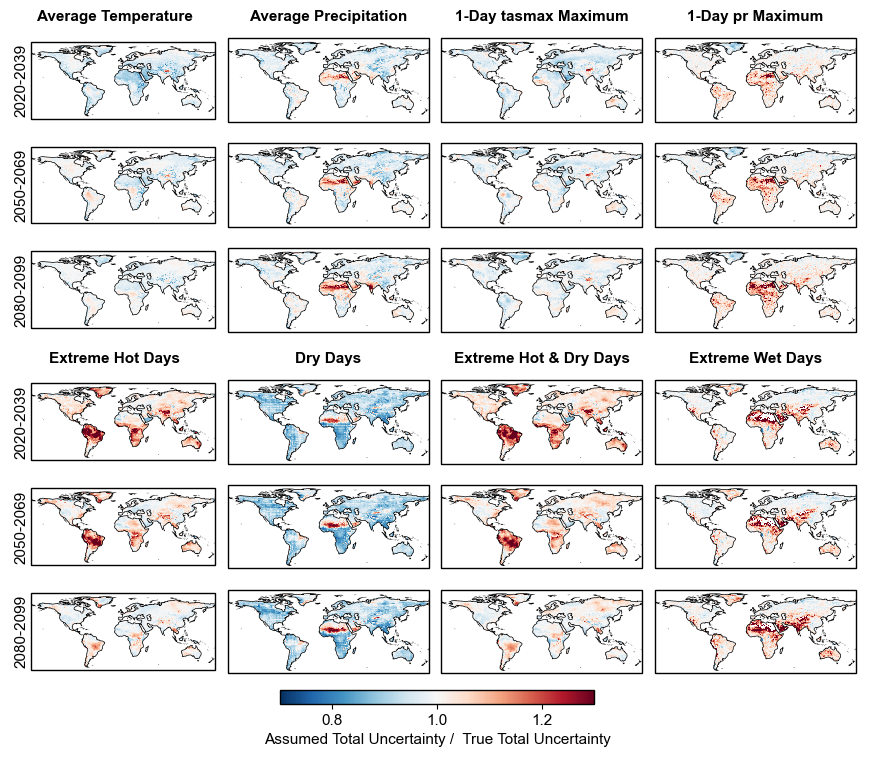

In [4]:
plt.rcParams["font.size"] = 11
fs = 11
deg = 4
scenario_id = "hs09"
const_iav = False
nonweighted = False

#################
#################
fig = plt.figure(figsize=(8.5, 7), constrained_layout=True)
subfigs = fig.subfigures(3, 4, height_ratios=[20, 20, 1])

############################
# Annual average tas
############################
axs = subfigs[0, 0].subplots(3, 1, subplot_kw={"projection": ccrs.PlateCarree()})
subfigs[0, 0].suptitle("Average Temperature", fontweight="bold", fontsize=fs)

metric = "avg"
var_id = "tas"

plot_uc_map_Utotal(metric, var_id, const_iav, deg, scenario_id, nonweighted, axs, subfigs[0, 0], True, False, "", 11)

############################
# Annual average pr
############################
axs = subfigs[0, 1].subplots(3, 1, subplot_kw={"projection": ccrs.PlateCarree()})
subfigs[0, 1].suptitle("Average Precipitation", fontweight="bold", fontsize=fs)

metric = "avg"
var_id = "pr"

plot_uc_map_Utotal(metric, var_id, const_iav, deg, scenario_id, nonweighted, axs, subfigs[0, 1], False, False, "", 11)

############################
# 1-day max tasmax
############################
axs = subfigs[0, 2].subplots(3, 1, subplot_kw={"projection": ccrs.PlateCarree()})
subfigs[0, 2].suptitle("1-Day tasmax Maximum", fontweight="bold", fontsize=fs)

metric = "max"
var_id = "tasmax"

plot_uc_map_Utotal(metric, var_id, const_iav, deg, scenario_id, nonweighted, axs, subfigs[0, 2], False, False, "", 11)

############################
# 1-day max pr
############################
axs = subfigs[0, 3].subplots(3, 1, subplot_kw={"projection": ccrs.PlateCarree()})
subfigs[0, 3].suptitle("1-Day pr Maximum", fontweight="bold", fontsize=fs)

metric = "max"
var_id = "pr"

plot_uc_map_Utotal(metric, var_id, const_iav, deg, scenario_id, nonweighted, axs, subfigs[0, 3], False, False, "", 11)

############################
# Extreme Hot Days
############################
axs = subfigs[1, 0].subplots(3, 1, subplot_kw={"projection": ccrs.PlateCarree()})
subfigs[1, 0].suptitle("Extreme Hot Days", fontweight="bold", fontsize=fs)

metric = "hot"
var_id = "tasmax_q99gmfd_count"

plot_uc_map_Utotal(metric, var_id, const_iav, deg, scenario_id, nonweighted, axs, subfigs[1, 0], True, False, "", 11)

############################
# Dry days
############################
axs = subfigs[1, 1].subplots(3, 1, subplot_kw={"projection": ccrs.PlateCarree()})
subfigs[1, 1].suptitle("Dry Days", fontweight="bold", fontsize=fs)

metric = "dry"
var_id = "count_lt_1"

plot_uc_map_Utotal(metric, var_id, const_iav, deg, scenario_id, nonweighted, axs, subfigs[1, 1], False, False, "", 11)

############################
# Hot & Dry dats
############################
axs = subfigs[1, 2].subplots(3, 1, subplot_kw={"projection": ccrs.PlateCarree()})
subfigs[1, 2].suptitle("Extreme Hot & Dry Days", fontweight="bold", fontsize=fs)

metric = "hotdry"
var_id = "hotdry_q99gmfd_count"

plot_uc_map_Utotal(metric, var_id, const_iav, deg, scenario_id, nonweighted, axs, subfigs[1, 2], False, False, "", 11)

############################
# Extreme Wet Days
############################
axs = subfigs[1, 3].subplots(3, 1, subplot_kw={"projection": ccrs.PlateCarree()})
subfigs[1, 3].suptitle("Extreme Wet Days", fontweight="bold", fontsize=fs)

metric = "wet"
var_id = "pr_q99gmfd_count"

plot_uc_map_Utotal(metric, var_id, const_iav, deg, scenario_id, nonweighted, axs, subfigs[1, 3], False, False, "", 11)

################
# Colorbar
################
cmap = "RdBu_r"
norm = Normalize(vmin=0.7, vmax=1.3)
sm = ScalarMappable(cmap=cmap, norm=norm)

cbar_ax = subfigs[2, 2].add_axes([-0.75, 0.1, 1.5, 0.8])
cbar = subfigs[2, 2].colorbar(
    sm, cax=cbar_ax, orientation="horizontal", label="Assumed Total Uncertainty /  True Total Uncertainty"
)

# plt.show()
plt.savefig("../figs/SI_total_uncertainty_comparison_maps.png", dpi=600)

### Timeseries plot

In [4]:
##############################
# UC timeseries
##############################
def plot_uc_timeseries(
    metric,
    var_id,
    region,
    deg,
    scenario_id,
    const_iav,
    title,
    ylabel,
    xlabel,
    legend,
    fig_label,
    fig_label_height,
    ax,
):
    """
    Region can either be a specific [lat, lon], a bounding [lat_min, lat_max, lon_min, lon_max],
    or an IPCC AR6 region name.
    """
    # Setup read paths
    uc_read_path = path_in + "uncertainty_partitioning/" + metric + "_deg" + str(deg) + ".nc"
    iav_read_path = path_in + "uncertainty_partitioning/" + metric + "_deg" + str(deg)
    utot_read_path = path_in + "total_uncertainty/" + metric + ".nc"

    if const_iav:
        iav_read_path += "_const_iav.nc"
    else:
        iav_read_path += "_nonconst_iav.nc"

    if metric in ["hot", "wet", "hotdry"]:
        var_id_string = var_id.replace("_count", "").replace("_streak", "").replace("pr_", "")
        iav_read_path = iav_read_path.replace(metric, metric + "_" + var_id_string)
        uc_read_path = uc_read_path.replace(metric, metric + "_" + var_id_string)
        utot_read_path = utot_read_path.replace(metric, metric + "_" + var_id_string)

    if metric == "hotdry":
        # This was me being silly
        iav_read_path = iav_read_path.replace("hotdry_hotdry_", "hotdry_")
        uc_read_path = uc_read_path.replace("hotdry_hotdry_", "hotdry_")
        utot_read_path = utot_read_path.replace("hotdry_hotdry_", "hotdry_")

    # Read
    ds_uc = xr.open_dataset(uc_read_path)[var_id]
    ds_iav = xr.open_dataset(iav_read_path)[var_id]
    Utotal_true = xr.open_dataset(utot_read_path)[var_id]

    if const_iav:
        ds_iav = ds_iav.expand_dims(dim={"time": np.arange(2015, 2100)})
    ds_iav = ds_iav.assign_coords(uncertainty="variability")
    if "member_id" in ds_iav.coords:
        ds_iav = ds_iav.isel(member_id=0).drop("member_id")

    # Select region
    if type(region) == str:
        mask = regionmask.defined_regions.ar6.land.mask(ds_uc)
        region_index = regionmask.defined_regions.ar6.land.map_keys(region)
        ds_uc_masked = ds_uc.where(mask == region_index)
        ds_iav_masked = ds_iav.where(mask == region_index)
        Utotal_true_masked = Utotal_true.where(mask == region_index)
    elif type(region) == list:
        if len(region) == 2:
            ds_uc_masked = ds_uc.sel(lat=region[0], lon=region[1], method="nearest")
            ds_iav_masked = ds_iav.sel(lat=region[0], lon=region[1], method="nearest")
            Utotal_true_masked = Utotal_true.sel(lat=region[0], lon=region[1], method="nearest")
        elif len(region) == 4:
            ds_uc_masked = ds_uc.sel(lat=slice(region[0], region[1]), lon=slice(region[2], region[3]))
            ds_iav_masked = ds_iav.sel(lat=slice(region[0], region[1]), lon=slice(region[2], region[3]))
            Utotal_true_masked = Utotal_true.sel(lat=slice(region[0], region[1]), lon=slice(region[2], region[3]))

    # Get 'total' uncertainty
    scenario = "scenario_" + scenario_id

    # Get fractions and average for each epoch
    Ufrac_model = 100 * ds_uc_masked.sel(uncertainty="model") / Utotal_true_masked
    Ufrac_scenario = 100 * ds_uc_masked.sel(uncertainty=scenario) / Utotal_true_masked
    Ufrac_ensemble = 100 * ds_uc_masked.sel(uncertainty="ensemble") / Utotal_true_masked
    Ufrac_iav = 100 * ds_iav_masked / Utotal_true_masked

    # Average over region
    if type(region) == str or (type(region) == list and len(region) == 4):
        Ufrac_model = Ufrac_model.mean(dim=["lat", "lon"], skipna=True)
        Ufrac_scenario = Ufrac_scenario.mean(dim=["lat", "lon"], skipna=True)
        Ufrac_ensemble = Ufrac_ensemble.mean(dim=["lat", "lon"], skipna=True)
        Ufrac_iav = Ufrac_iav.mean(dim=["lat", "lon"], skipna=True)

    # Construct plotting dict
    uncert_dict = {
        "Scenario": Ufrac_scenario.to_numpy().flatten(),
        "Model": Ufrac_model.to_numpy().flatten(),
        "Downscaling": Ufrac_ensemble.to_numpy().flatten(),
        "Variability": Ufrac_iav.to_numpy().flatten(),
    }

    # Make plot
    ax.stackplot(
        np.arange(2015, 2100),
        uncert_dict.values(),
        labels=uncert_dict.keys(),
        alpha=1,
        colors=["#00CC89", "#6869B3", "#CC883C", "#FFFF99"],
        edgecolor="white",
        lw=1.5,
    )

    if legend:
        ax.legend(loc="upper left", ncol=2, columnspacing=0.6, handletextpad=0.1, fontsize=10)

    if const_iav:
        yr_min, yr_max = 2015, 2100
    else:
        yr_min, yr_max = 2020, 2095
    ax.set_xlim([yr_min, yr_max - 1])

    ax.set_xticks([2030, 2050, 2070, 2090])
    ax.set_ylim([0, 150])
    ax.axhline(y=100, color="black", ls="--", lw=0.5)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_xlabel(xlabel, fontsize=11)
    ax.set_title(title, fontsize=11, loc="center")

    if fig_label:
        ax.text(
            0.05,
            fig_label_height,
            fig_label,
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
        )

In [5]:
################
# Cities
################
city_list = {
    "chicago": [41.881944, -87.627778],
    "lagos": [6.455027, 3.384082],
    "cairo": [30.044444, 31.235833],
    "seattle": [47.609722, -122.333056],
    "delhi": [28.613895, 77.209006],
    # "delhiP": [27.125, 76.625],
    "houston": [29.762778, -95.383056],
    "mexicocity": [19.433333, -99.133333],
    "denver": [39.7392, -104.985],
    "nyc": [40.712778, -74.006111],
    "mumbai": [19.076111, 72.8775],
    "jakarta": [-6.175, 106.8275],
    "sanfrancisco": [37.7775, -122.416389],
    "rio": [-22.911111, -43.205556],
    "capetown": [33.925278, 18.423889],
}

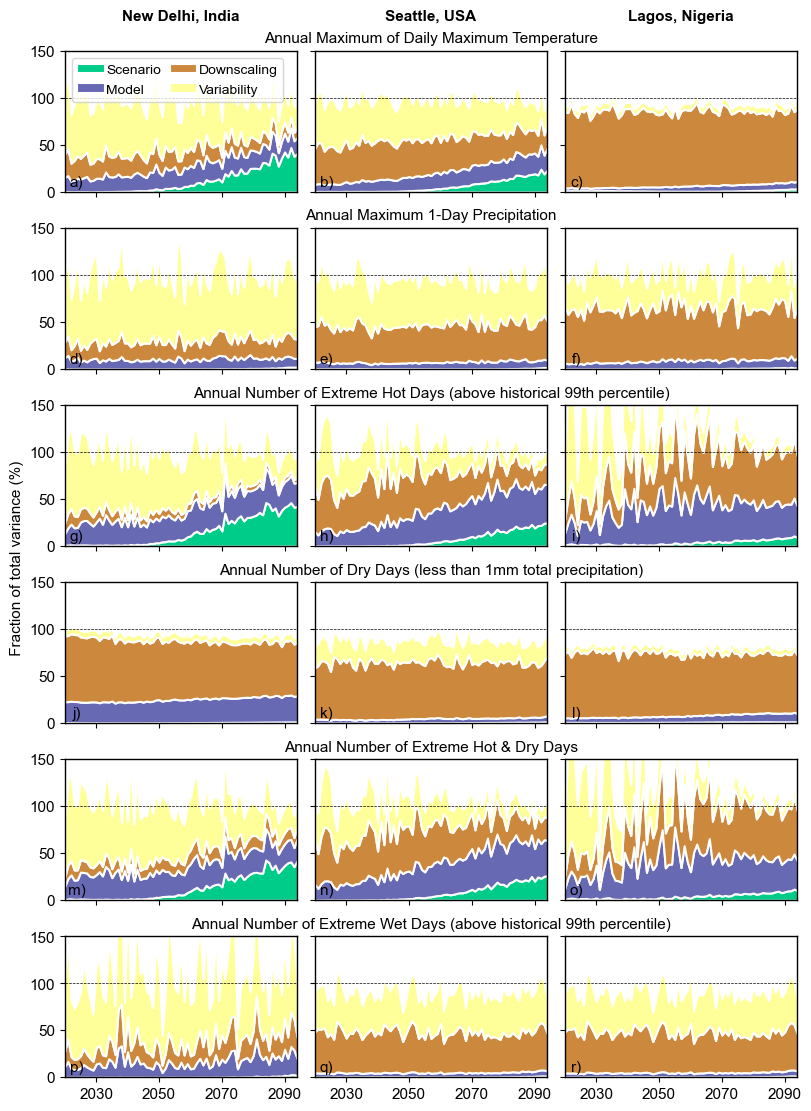

In [6]:
fig, axs = plt.subplots(
    nrows=7,
    ncols=3,
    figsize=(8, 11),
    constrained_layout=True,
    sharey="row",
    sharex=True,
    gridspec_kw={"height_ratios": [1, 10, 10, 10, 10, 10, 10]},
)

# Setup
plt.rcParams["font.size"] = 11
deg = 4
scenario_id = "hs09"
const_iav = False

# Cities
city1 = "delhi"
city2 = "seattle"
city3 = "lagos"

# Labels
left, width = 0.25, 0.5
bottom, height = 0.25, 0.5
right = left + width
top = bottom + height

axs[0, 0].text(
    x=0.5 * (left + right),
    y=0.5 * (bottom + top),
    s="New Delhi, India",
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 0].transAxes,
    fontweight="bold",
    fontsize=11,
)
axs[0, 0].axis("off")

axs[0, 1].text(
    x=0.5 * (left + right),
    y=0.5 * (bottom + top),
    s="Seattle, USA",
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 1].transAxes,
    fontweight="bold",
    fontsize=11,
)
axs[0, 1].axis("off")

axs[0, 2].text(
    x=0.5 * (left + right),
    y=0.5 * (bottom + top),
    s="Lagos, Nigeria",
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 2].transAxes,
    fontweight="bold",
    fontsize=11,
)
axs[0, 2].axis("off")

# Tasmax maxima
plot_uc_timeseries(
    metric="max",
    var_id="tasmax",
    region=city_list[city1],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    xlabel="",
    ylabel="",
    legend=True,
    fig_label="a)",
    fig_label_height=0.07,
    ax=axs[1, 0],
)
axs[1, 0].set_yticks([0, 50, 100, 150])
plot_uc_timeseries(
    metric="max",
    var_id="tasmax",
    region=city_list[city2],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="Annual Maximum of Daily Maximum Temperature",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="b)",
    fig_label_height=0.07,
    ax=axs[1, 1],
)
plot_uc_timeseries(
    metric="max",
    var_id="tasmax",
    region=city_list[city3],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="c)",
    fig_label_height=0.07,
    ax=axs[1, 2],
)

# Pr maxima
plot_uc_timeseries(
    metric="max",
    var_id="pr",
    region=city_list[city1],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="d)",
    fig_label_height=0.07,
    ax=axs[2, 0],
)
axs[2, 0].set_yticks([0, 50, 100, 150])
plot_uc_timeseries(
    metric="max",
    var_id="pr",
    region=city_list[city2],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="Annual Maximum 1-Day Precipitation",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="e)",
    fig_label_height=0.07,
    ax=axs[2, 1],
)
plot_uc_timeseries(
    metric="max",
    var_id="pr",
    region=city_list[city3],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="f)",
    fig_label_height=0.07,
    ax=axs[2, 2],
)

# Extreme Hot Days: count
plot_uc_timeseries(
    metric="hot",
    var_id="tasmax_q99gmfd_count",
    region=city_list[city1],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="g)",
    fig_label_height=0.07,
    ax=axs[3, 0],
)
axs[3, 0].set_yticks([0, 50, 100, 150])
plot_uc_timeseries(
    metric="hot",
    var_id="tasmax_q99gmfd_count",
    region=city_list[city2],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="Annual Number of Extreme Hot Days (above historical 99th percentile)",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="h)",
    fig_label_height=0.07,
    ax=axs[3, 1],
)
plot_uc_timeseries(
    metric="hot",
    var_id="tasmax_q99gmfd_count",
    region=city_list[city3],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="i)",
    fig_label_height=0.07,
    ax=axs[3, 2],
)

# Dry days: count
plot_uc_timeseries(
    metric="dry",
    var_id="count_lt_1",
    region=city_list[city1],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    ylabel="\t\t\t\t\t\t\t\t\t\t\t Fraction of total variance (%)".replace("\t", "    "),
    xlabel="",
    legend=False,
    fig_label="j)",
    fig_label_height=0.07,
    ax=axs[4, 0],
)
plot_uc_timeseries(
    metric="dry",
    var_id="count_lt_1",
    region=city_list[city2],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="Annual Number of Dry Days (less than 1mm total precipitation)",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="k)",
    fig_label_height=0.07,
    ax=axs[4, 1],
)
plot_uc_timeseries(
    metric="dry",
    var_id="count_lt_1",
    region=city_list[city3],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="l)",
    fig_label_height=0.07,
    ax=axs[4, 2],
)

# Extreme Hot & Dry Days: count
plot_uc_timeseries(
    metric="hotdry",
    var_id="hotdry_q99gmfd_count",
    region=city_list[city1],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="m)",
    fig_label_height=0.07,
    ax=axs[5, 0],
)
plot_uc_timeseries(
    metric="hotdry",
    var_id="hotdry_q99gmfd_count",
    region=city_list[city2],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="Annual Number of Extreme Hot & Dry Days",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="n)",
    fig_label_height=0.07,
    ax=axs[5, 1],
)
plot_uc_timeseries(
    metric="hotdry",
    var_id="hotdry_q99gmfd_count",
    region=city_list[city3],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="o)",
    fig_label_height=0.07,
    ax=axs[5, 2],
)

# Extreme Wet Days: count
plot_uc_timeseries(
    metric="wet",
    var_id="pr_q99gmfd_count",
    region=city_list[city1],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="p)",
    fig_label_height=0.07,
    ax=axs[6, 0],
)
plot_uc_timeseries(
    metric="wet",
    var_id="pr_q99gmfd_count",
    region=city_list[city2],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="Annual Number of Extreme Wet Days (above historical 99th percentile)",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="q)",
    fig_label_height=0.07,
    ax=axs[6, 1],
)
plot_uc_timeseries(
    metric="wet",
    var_id="pr_q99gmfd_count",
    region=city_list[city2],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="r)",
    fig_label_height=0.07,
    ax=axs[6, 2],
)

plt.savefig("../figs/SI_total_uncertainty_comparison_cities.png", dpi=600)
# plt.show()

# Coastal effects

In [7]:
################
# Cities
################
city_list = {
    "chicago": [41.881944, -87.627778],
    "lagos": [6.455027, 3.384082],
    "cairo": [30.044444, 31.235833],
    "seattle": [47.609722, -122.333056],
    "delhi": [28.613895, 77.209006],
    "houston": [29.762778, -95.383056],
    "mexicocity": [19.433333, -99.133333],
    "denver": [39.7392, -104.985],
    "nyc": [40.712778, -74.006111],
    "mumbai": [19.076111, 72.8775],
    "jakarta": [-6.175, 106.8275],
    "sanfrancisco": [37.7775, -122.416389],
    "rio": [-22.911111, -43.205556],
    "capetown": [-33.925278, 18.423889],
}

In [8]:
def obs_gridpoint_comparison(lat, lon, var_id, markercolor, title, cbar, fs, ax):
    # Location of historical quantiles from obs: update for reproduction
    obs_path = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/obs_data/quantiles/"

    # Correct  longitudes
    def fix_lon(ds):
        ds["lon"] = np.where(ds["lon"] > 180, ds["lon"] - 360, ds["lon"])
        return ds.sortby("lon")

    # Read historical quantiles
    if var_id[0] == "t":
        var_read = "temperature"
    elif var_id[0] == "p":
        var_read = "precip"

    ds_gmfd = fix_lon(xr.open_dataset(obs_path + "gmfd_" + var_read + "_quantiles_nex-cil-deepsd.nc"))

    ds_era5 = fix_lon(
        xr.open_dataset(
            obs_path + "era5_" + var_read + "_quantiles_nex-cil-deepsd/",
            engine="zarr",
        )
    )

    # Plot map
    lat_min, lat_max = lat - 2, lat + 2.0
    lon_min, lon_max = lon - 2, lon + 2.0

    ratio = (
        ds_era5.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))[var_id]
        / ds_gmfd.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))[var_id]
    )

    if cbar:
        ratio.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            vmin=0.7,
            vmax=1.3,
            cmap="RdBu_r",
            zorder=1,
            cbar_kwargs={
                "orientation": "horizontal",
                "label": None,
                "shrink": 0.99,
                "pad": 0.08,
            },
        )
    else:
        ratio.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            vmin=0.7,
            vmax=1.3,
            cmap="RdBu_r",
            zorder=1,
            add_colorbar=False,
        )
    ax.coastlines()
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels={"top": "x", "left": "y"},
        linewidth=1,
        color="silver",
        alpha=0.5,
        linestyle="--",
    )
    gl.xlabel_style = {"size": fs}
    gl.ylabel_style = {"size": fs}

    ax.set_title(title, fontsize=fs)

    ax.scatter(x=lon, y=lat, marker=".", color=markercolor, zorder=10, s=5)

In [9]:
def single_model_plot(lat, lon, metric, var_id, legend, title, ylabel, fs, ax):
    # Correct  longitudes
    def fix_lon(ds):
        ds["lon"] = np.where(ds["lon"] > 180, ds["lon"] - 360, ds["lon"])
        return ds.sortby("lon")

    # Location of metrics outputs
    path_in = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/"

    # Read projections for single model
    model = "CanESM5"

    ds_nex = fix_lon(xr.open_dataset(path_in + "nex-gddp/" + metric + "/" + model + ".nc"))
    ds_isi = fix_lon(xr.open_dataset(path_in + "isimip3b/regridded/conservative/" + metric + "/" + model + ".nc"))
    ds_cil = fix_lon(
        xr.open_dataset(
            path_in + "cil-gdpcir/" + metric + "/" + model,
            engine="zarr",
        )
    )
    ds_gard = fix_lon(
        xr.open_dataset(path_in + "carbonplan/regridded/conservative/GARD-SV/" + metric + "/" + model + ".nc")
    )
    ds_deep = fix_lon(
        xr.open_dataset(
            path_in + "carbonplan/native_grid/DeepSD-BC/" + metric + "/" + model,
            engine="zarr",
        )
    )

    # Make plot
    lw = 2
    color_dict = {
        "NEX": "#117733",
        "CIL": "#44AA99",
        "ISIMIP": "#DDCC77",
        "GARD-SV": "#CC6677",
        "DeepSD-BC": "#882255",
    }

    ax.plot(
        ds_nex.time.dt.year,
        ds_nex.sel(ssp="ssp370").sel(lat=lat, lon=lon, method="nearest")[var_id].values,
        label="NEX",
        color=color_dict["NEX"],
        lw=lw,
    )
    ax.plot(
        ds_cil.time.dt.year,
        ds_cil.sel(ssp="ssp370").sel(lat=lat, lon=lon, method="nearest")[var_id].values,
        label="CIL",
        color=color_dict["CIL"],
        lw=lw,
    )
    ax.plot(
        ds_isi.time.dt.year,
        ds_isi.sel(ssp="ssp370").sel(lat=lat, lon=lon, method="nearest")[var_id].values,
        label="ISIMIP",
        color=color_dict["ISIMIP"],
        lw=lw,
    )
    ax.plot(
        ds_gard.time.dt.year,
        ds_gard.sel(ssp="ssp370").sel(lat=lat, lon=lon, method="nearest")[var_id].values,
        label="GARD",
        color=color_dict["GARD-SV"],
        lw=lw,
    )
    ax.plot(
        ds_deep.time.dt.year,
        ds_deep.sel(ssp="ssp370").sel(lat=lat, lon=lon, method="nearest")[var_id].values[0],
        label="DeepSD",
        color=color_dict["DeepSD-BC"],
        lw=lw,
    )

    ax.grid(alpha=0.5)
    if legend:
        ax.legend(
            ncol=3,
            fontsize=fs - 1,
            handlelength=0.8,
            columnspacing=0.2,
            handletextpad=0.1,
        )
    if title:
        ax.set_title(title, fontsize=fs + 1, loc="center")
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=fs)

In [18]:
##############################
# UC timeseries
##############################
def plot_uc_timeseries(
    metric,
    var_id,
    region,
    deg,
    scenario_id,
    const_iav,
    title,
    ylabel,
    xlabel,
    legend,
    fig_label,
    fig_label_height,
    ax,
):
    """
    Region can either be a specific [lat, lon], a bounding [lat_min, lat_max, lon_min, lon_max],
    or an IPCC AR6 region name.
    """
    # Setup read paths
    path_in = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/results/"
    uc_read_path = path_in + "uncertainty_partitioning/" + metric + "_deg" + str(deg) + ".nc"

    iav_read_path = path_in + "uncertainty_partitioning/" + metric + "_deg" + str(deg)
    if const_iav:
        iav_read_path += "_const_iav.nc"
    else:
        iav_read_path += "_nonconst_iav.nc"

    if metric in ["hot", "wet", "hotdry"]:
        var_id_string = var_id.replace("_count", "").replace("_streak", "").replace("pr_", "")
        uc_read_path = uc_read_path.replace(metric, metric + "_" + var_id_string)
        iav_read_path = iav_read_path.replace(metric, metric + "_" + var_id_string)
    if metric == "hotdry":
        # This was me being silly
        iav_read_path = iav_read_path.replace("hotdry_hotdry_", "hotdry_")
        uc_read_path = uc_read_path.replace("hotdry_hotdry_", "hotdry_")

    # Read
    ds_uc = xr.open_dataset(uc_read_path)[var_id]

    ds_iav = xr.open_dataset(iav_read_path)[var_id]
    if const_iav:
        ds_iav = ds_iav.expand_dims(dim={"time": np.arange(2015, 2100)})
    ds_iav = ds_iav.assign_coords(uncertainty="variability")
    if "member_id" in ds_iav.coords:
        ds_iav = ds_iav.isel(member_id=0).drop("member_id")

    # Select region
    if type(region) == str:
        mask = regionmask.defined_regions.ar6.land.mask(ds_uc)
        region_index = regionmask.defined_regions.ar6.land.map_keys(region)
        ds_uc_masked = ds_uc.where(mask == region_index)
        ds_iav_masked = ds_iav.where(mask == region_index)
    elif type(region) == list:
        if len(region) == 2:
            ds_uc_masked = ds_uc.sel(lat=region[0], lon=region[1], method="nearest")
            ds_iav_masked = ds_iav.sel(lat=region[0], lon=region[1], method="nearest")
        elif len(region) == 4:
            ds_uc_masked = ds_uc.sel(lat=slice(region[0], region[1]), lon=slice(region[2], region[3]))
            ds_iav_masked = ds_iav.sel(lat=slice(region[0], region[1]), lon=slice(region[2], region[3]))

    # Get 'total' uncertainty
    scenario = "scenario_" + scenario_id

    Utotal = (
        ds_uc_masked.sel(uncertainty="model")
        + ds_uc_masked.sel(uncertainty=scenario)
        + ds_uc_masked.sel(uncertainty="ensemble")
        + ds_iav_masked
    )

    # Get fractions and average for each epoch
    Ufrac_model = 100 * ds_uc_masked.sel(uncertainty="model") / Utotal
    Ufrac_scenario = 100 * ds_uc_masked.sel(uncertainty=scenario) / Utotal
    Ufrac_ensemble = 100 * ds_uc_masked.sel(uncertainty="ensemble") / Utotal
    Ufrac_iav = 100 * ds_iav_masked / Utotal

    # Average over region
    if type(region) == str or (type(region) == list and len(region) == 4):
        Ufrac_model = Ufrac_model.mean(dim=["lat", "lon"], skipna=True)
        Ufrac_scenario = Ufrac_scenario.mean(dim=["lat", "lon"], skipna=True)
        Ufrac_ensemble = Ufrac_ensemble.mean(dim=["lat", "lon"], skipna=True)
        Ufrac_iav = Ufrac_iav.mean(dim=["lat", "lon"], skipna=True)

    # Construct plotting dict
    uncert_dict = {
        "Scenario": Ufrac_scenario.to_numpy().flatten(),
        "Model": Ufrac_model.to_numpy().flatten(),
        "Downscaling": Ufrac_ensemble.to_numpy().flatten(),
        "Variability": Ufrac_iav.to_numpy().flatten(),
    }

    # Make plot
    ax.stackplot(
        np.arange(2015, 2100),
        uncert_dict.values(),
        labels=uncert_dict.keys(),
        alpha=1,
        colors=["#00CC89", "#6869B3", "#CC883C", "#FFFF99"],
        edgecolor="white",
        lw=1.5,
    )

    if legend:
        ax.legend(loc="upper left", ncol=2, columnspacing=0.6, handletextpad=0.1, fontsize=10)

    if const_iav:
        yr_min, yr_max = 2015, 2100
    else:
        yr_min, yr_max = 2020, 2095
    ax.set_xlim([yr_min, yr_max - 1])

    ax.set_xticks([2030, 2050, 2070, 2090])
    ax.set_ylim([0, 100])
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title, fontsize=10, loc="center")

    if fig_label:
        ax.text(
            0.05,
            fig_label_height,
            fig_label,
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
        )

### Lagos

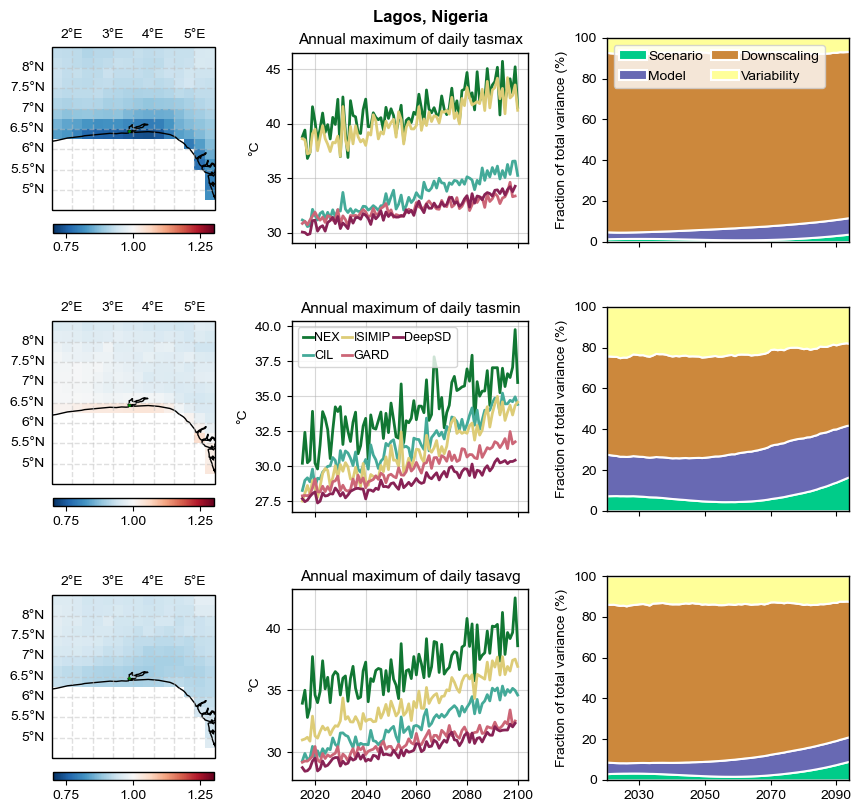

In [19]:
# Setup
city = "lagos"
fs = 10
plt.rcParams["font.size"] = fs

# Figure
fig = plt.figure(constrained_layout=True, figsize=(8.5, 8))
subfigs = fig.subfigures(1, 3, wspace=0.05, width_ratios=[0.7, 1, 1])
fig.suptitle("Lagos, Nigeria", fontweight="bold")

# Maps
axs = subfigs[0].subplots(
    3,
    1,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=dict(hspace=0.2),
)

obs_gridpoint_comparison(
    lat=city_list[city][0],
    lon=city_list[city][1],
    var_id="tasmax_q99",
    markercolor="g",
    title="",
    cbar=True,
    fs=fs,
    ax=axs[0],
)

obs_gridpoint_comparison(
    lat=city_list[city][0],
    lon=city_list[city][1],
    var_id="tasmin_q99",
    markercolor="g",
    title="",
    cbar=True,
    fs=fs,
    ax=axs[1],
)

obs_gridpoint_comparison(
    lat=city_list[city][0],
    lon=city_list[city][1],
    var_id="tas_q99",
    markercolor="g",
    title="",
    cbar=True,
    fs=fs,
    ax=axs[2],
)

# Timeseries
axs = subfigs[1].subplots(
    3,
    1,
    sharex=True,
    gridspec_kw=dict(hspace=0.2),
)

single_model_plot(
    lat=city_list[city][0],
    lon=city_list[city][1],
    metric="max",
    var_id="tasmax",
    legend=False,
    title="Annual maximum of daily tasmax",
    ylabel="\N{DEGREE SIGN}C",
    fs=fs,
    ax=axs[0],
)
single_model_plot(
    lat=city_list[city][0],
    lon=city_list[city][1],
    metric="max",
    var_id="tasmin",
    legend=True,
    title="Annual maximum of daily tasmin",
    ylabel="\N{DEGREE SIGN}C",
    fs=fs,
    ax=axs[1],
)
single_model_plot(
    lat=city_list[city][0],
    lon=city_list[city][1],
    metric="max",
    var_id="tas",
    legend=False,
    title="Annual maximum of daily tasavg",
    ylabel="\N{DEGREE SIGN}C",
    fs=fs,
    ax=axs[2],
)

# Full UC
axs = subfigs[2].subplots(
    3,
    1,
    sharex=True,
    gridspec_kw=dict(hspace=0.2),
)

deg = 4
scenario_id = "hs09"
const_iav = False

plot_uc_timeseries(
    metric="max",
    var_id="tasmax",
    region=[city_list[city][0], city_list[city][1]],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    ylabel="Fraction of total variance (%)",
    xlabel="",
    legend=True,
    fig_label=False,
    fig_label_height=0,
    ax=axs[0],
)

plot_uc_timeseries(
    metric="max",
    var_id="tasmin",
    region=[city_list[city][0], city_list[city][1]],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    ylabel="Fraction of total variance (%)",
    xlabel="",
    legend=False,
    fig_label=False,
    fig_label_height=0,
    ax=axs[1],
)

plot_uc_timeseries(
    metric="max",
    var_id="tas",
    region=[city_list[city][0], city_list[city][1]],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    ylabel="Fraction of total variance (%)",
    xlabel="",
    legend=False,
    fig_label=False,
    fig_label_height=0,
    ax=axs[2],
)

plt.savefig("../figs/SI_lagos_temp_max_comparison.png", dpi=600)

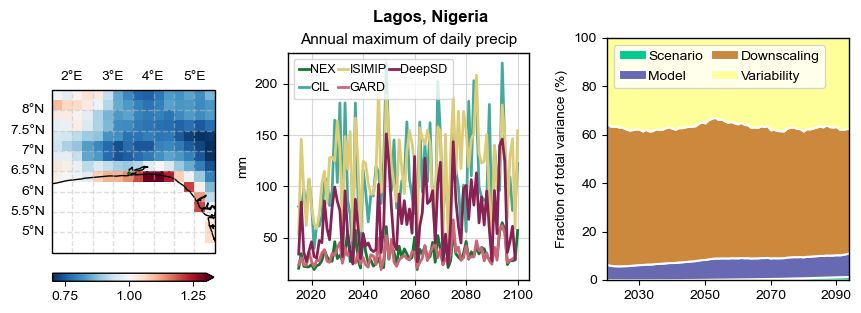

In [20]:
# Setup
city = "lagos"
fs = 10
plt.rcParams["font.size"] = fs

# Figure
fig = plt.figure(constrained_layout=True, figsize=(8.5, 3))
subfigs = fig.subfigures(1, 3, wspace=0.05, width_ratios=[0.7, 1, 1])
fig.suptitle("Lagos, Nigeria", fontweight="bold")

# Maps
axs = subfigs[0].subplots(
    1,
    1,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=dict(hspace=0.2),
)

obs_gridpoint_comparison(
    lat=city_list[city][0],
    lon=city_list[city][1],
    var_id="pr_q99",
    markercolor="g",
    title="",
    cbar=True,
    fs=fs,
    ax=axs,
)

# Timeseries
axs = subfigs[1].subplots(
    1,
    1,
    sharex=True,
    gridspec_kw=dict(hspace=0.2),
)

single_model_plot(
    lat=city_list[city][0],
    lon=city_list[city][1],
    metric="max",
    var_id="pr",
    legend=True,
    title="Annual maximum of daily precip",
    ylabel="mm",
    fs=fs,
    ax=axs,
)

# Full UC
axs = subfigs[2].subplots(
    1,
    1,
    sharex=True,
    gridspec_kw=dict(hspace=0.2),
)

deg = 4
scenario_id = "hs09"
const_iav = False

plot_uc_timeseries(
    metric="max",
    var_id="pr",
    region=[city_list[city][0], city_list[city][1]],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    ylabel="Fraction of total variance (%)",
    xlabel="",
    legend=True,
    fig_label=False,
    fig_label_height=0,
    ax=axs,
)

plt.savefig("../figs/SI_lagos_pr_max_comparison.png", dpi=600)

### Mumbai

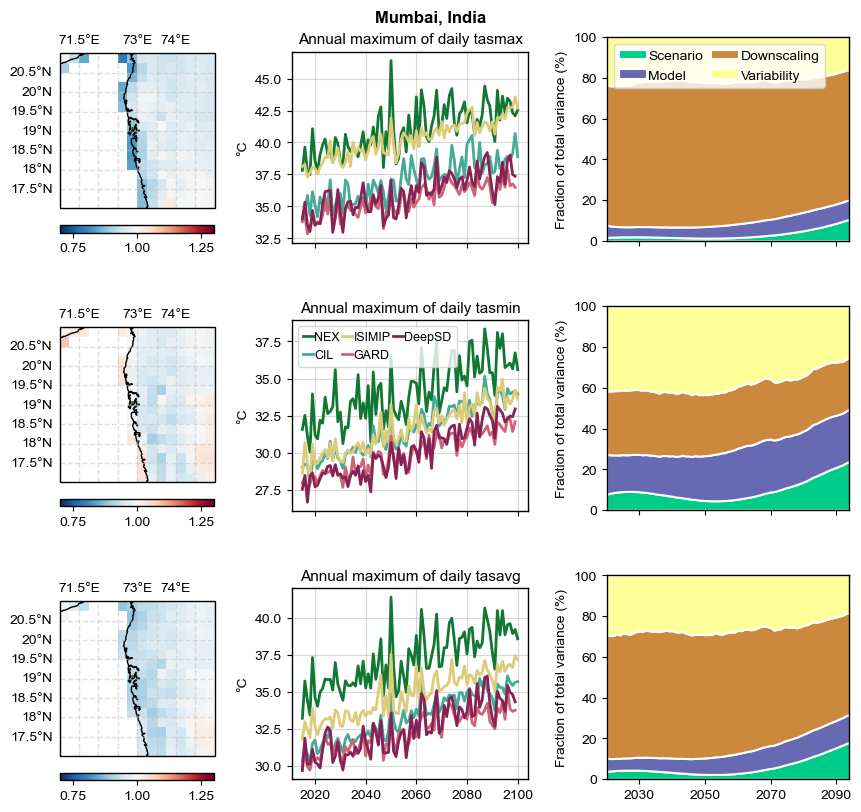

In [21]:
# Setup
city = "mumbai"
fs = 10
plt.rcParams["font.size"] = fs

# Figure
fig = plt.figure(constrained_layout=True, figsize=(8.5, 8))
subfigs = fig.subfigures(1, 3, wspace=0.05, width_ratios=[0.7, 1, 1])
fig.suptitle("Mumbai, India", fontweight="bold")

# Maps
axs = subfigs[0].subplots(
    3,
    1,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=dict(hspace=0.2),
)

obs_gridpoint_comparison(
    lat=city_list[city][0],
    lon=city_list[city][1],
    var_id="tasmax_q99",
    markercolor="g",
    title="",
    cbar=True,
    fs=fs,
    ax=axs[0],
)

obs_gridpoint_comparison(
    lat=city_list[city][0],
    lon=city_list[city][1],
    var_id="tasmin_q99",
    markercolor="g",
    title="",
    cbar=True,
    fs=fs,
    ax=axs[1],
)

obs_gridpoint_comparison(
    lat=city_list[city][0],
    lon=city_list[city][1],
    var_id="tas_q99",
    markercolor="g",
    title="",
    cbar=True,
    fs=fs,
    ax=axs[2],
)

# Timeseries
axs = subfigs[1].subplots(
    3,
    1,
    sharex=True,
    gridspec_kw=dict(hspace=0.2),
)

single_model_plot(
    lat=city_list[city][0],
    lon=city_list[city][1],
    metric="max",
    var_id="tasmax",
    legend=False,
    title="Annual maximum of daily tasmax",
    ylabel="\N{DEGREE SIGN}C",
    fs=fs,
    ax=axs[0],
)
single_model_plot(
    lat=city_list[city][0],
    lon=city_list[city][1],
    metric="max",
    var_id="tasmin",
    legend=True,
    title="Annual maximum of daily tasmin",
    ylabel="\N{DEGREE SIGN}C",
    fs=fs,
    ax=axs[1],
)
single_model_plot(
    lat=city_list[city][0],
    lon=city_list[city][1],
    metric="max",
    var_id="tas",
    legend=False,
    title="Annual maximum of daily tasavg",
    ylabel="\N{DEGREE SIGN}C",
    fs=fs,
    ax=axs[2],
)

# Full UC
axs = subfigs[2].subplots(
    3,
    1,
    sharex=True,
    gridspec_kw=dict(hspace=0.2),
)

deg = 4
scenario_id = "hs09"
const_iav = False

plot_uc_timeseries(
    metric="max",
    var_id="tasmax",
    region=[city_list[city][0], city_list[city][1]],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    ylabel="Fraction of total variance (%)",
    xlabel="",
    legend=True,
    fig_label=False,
    fig_label_height=0,
    ax=axs[0],
)

plot_uc_timeseries(
    metric="max",
    var_id="tasmin",
    region=[city_list[city][0], city_list[city][1]],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    ylabel="Fraction of total variance (%)",
    xlabel="",
    legend=False,
    fig_label=False,
    fig_label_height=0,
    ax=axs[1],
)

plot_uc_timeseries(
    metric="max",
    var_id="tas",
    region=[city_list[city][0], city_list[city][1]],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    ylabel="Fraction of total variance (%)",
    xlabel="",
    legend=False,
    fig_label=False,
    fig_label_height=0,
    ax=axs[2],
)

plt.savefig("../figs/SI_mumbai_temp_max_comparison.png", dpi=600)

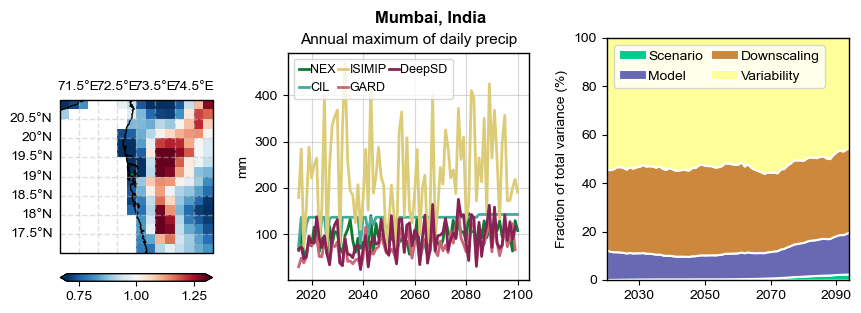

In [22]:
# Setup
city = "mumbai"
fs = 10
plt.rcParams["font.size"] = fs

# Figure
fig = plt.figure(constrained_layout=True, figsize=(8.5, 3))
subfigs = fig.subfigures(1, 3, wspace=0.05, width_ratios=[0.7, 1, 1])
fig.suptitle("Mumbai, India", fontweight="bold")

# Maps
axs = subfigs[0].subplots(
    1,
    1,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=dict(hspace=0.2),
)

obs_gridpoint_comparison(
    lat=city_list[city][0],
    lon=city_list[city][1],
    var_id="pr_q99",
    markercolor="g",
    title="",
    cbar=True,
    fs=fs,
    ax=axs,
)

# Timeseries
axs = subfigs[1].subplots(
    1,
    1,
    sharex=True,
    gridspec_kw=dict(hspace=0.2),
)

single_model_plot(
    lat=city_list[city][0],
    lon=city_list[city][1],
    metric="max",
    var_id="pr",
    legend=True,
    title="Annual maximum of daily precip",
    ylabel="mm",
    fs=fs,
    ax=axs,
)

# Full UC
axs = subfigs[2].subplots(
    1,
    1,
    sharex=True,
    gridspec_kw=dict(hspace=0.2),
)

deg = 4
scenario_id = "hs09"
const_iav = False

plot_uc_timeseries(
    metric="max",
    var_id="pr",
    region=[city_list[city][0], city_list[city][1]],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    ylabel="Fraction of total variance (%)",
    xlabel="",
    legend=True,
    fig_label=False,
    fig_label_height=0,
    ax=axs,
)

plt.savefig("../figs/SI_mumbai_pr_max_comparison.png", dpi=600)

### Rio

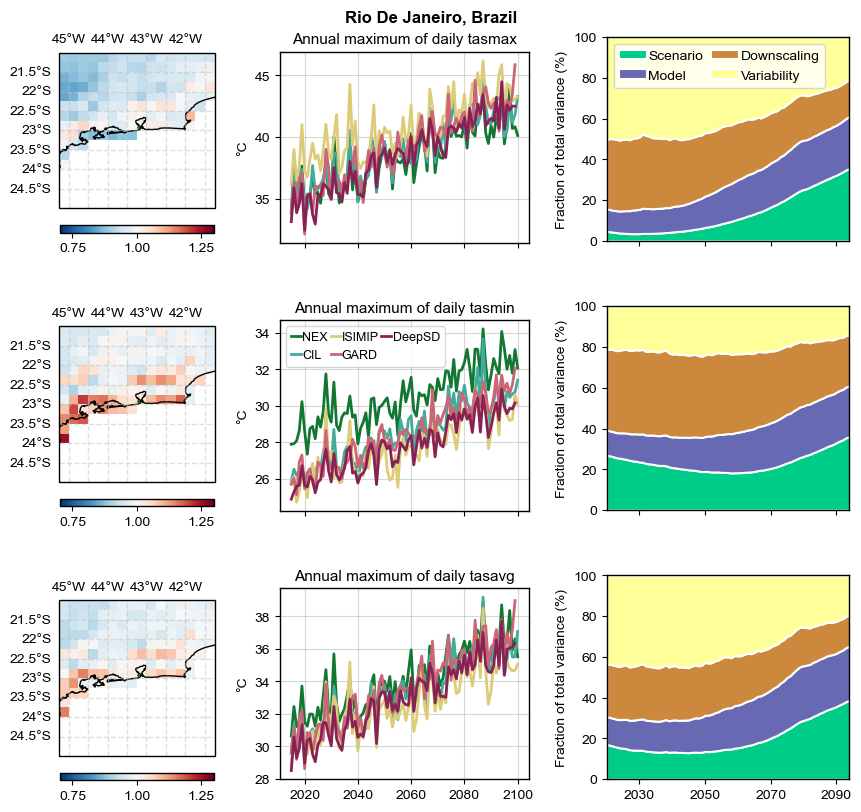

In [23]:
# Setup
city = "rio"
fs = 10
plt.rcParams["font.size"] = fs

# Figure
fig = plt.figure(constrained_layout=True, figsize=(8.5, 8))
subfigs = fig.subfigures(1, 3, wspace=0.05, width_ratios=[0.7, 1, 1])
fig.suptitle("Rio De Janeiro, Brazil", fontweight="bold")

# Maps
axs = subfigs[0].subplots(
    3,
    1,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=dict(hspace=0.2),
)

obs_gridpoint_comparison(
    lat=city_list[city][0],
    lon=city_list[city][1],
    var_id="tasmax_q99",
    markercolor="g",
    title="",
    cbar=True,
    fs=fs,
    ax=axs[0],
)

obs_gridpoint_comparison(
    lat=city_list[city][0],
    lon=city_list[city][1],
    var_id="tasmin_q99",
    markercolor="g",
    title="",
    cbar=True,
    fs=fs,
    ax=axs[1],
)

obs_gridpoint_comparison(
    lat=city_list[city][0],
    lon=city_list[city][1],
    var_id="tas_q99",
    markercolor="g",
    title="",
    cbar=True,
    fs=fs,
    ax=axs[2],
)

# Timeseries
axs = subfigs[1].subplots(
    3,
    1,
    sharex=True,
    gridspec_kw=dict(hspace=0.2),
)

single_model_plot(
    lat=city_list[city][0],
    lon=city_list[city][1],
    metric="max",
    var_id="tasmax",
    legend=False,
    title="Annual maximum of daily tasmax",
    ylabel="\N{DEGREE SIGN}C",
    fs=fs,
    ax=axs[0],
)
single_model_plot(
    lat=city_list[city][0],
    lon=city_list[city][1],
    metric="max",
    var_id="tasmin",
    legend=True,
    title="Annual maximum of daily tasmin",
    ylabel="\N{DEGREE SIGN}C",
    fs=fs,
    ax=axs[1],
)
single_model_plot(
    lat=city_list[city][0],
    lon=city_list[city][1],
    metric="max",
    var_id="tas",
    legend=False,
    title="Annual maximum of daily tasavg",
    ylabel="\N{DEGREE SIGN}C",
    fs=fs,
    ax=axs[2],
)

# Full UC
axs = subfigs[2].subplots(
    3,
    1,
    sharex=True,
    gridspec_kw=dict(hspace=0.2),
)

deg = 4
scenario_id = "hs09"
const_iav = False

plot_uc_timeseries(
    metric="max",
    var_id="tasmax",
    region=[city_list[city][0], city_list[city][1]],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    ylabel="Fraction of total variance (%)",
    xlabel="",
    legend=True,
    fig_label=False,
    fig_label_height=0,
    ax=axs[0],
)

plot_uc_timeseries(
    metric="max",
    var_id="tasmin",
    region=[city_list[city][0], city_list[city][1]],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    ylabel="Fraction of total variance (%)",
    xlabel="",
    legend=False,
    fig_label=False,
    fig_label_height=0,
    ax=axs[1],
)

plot_uc_timeseries(
    metric="max",
    var_id="tas",
    region=[city_list[city][0], city_list[city][1]],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    ylabel="Fraction of total variance (%)",
    xlabel="",
    legend=False,
    fig_label=False,
    fig_label_height=0,
    ax=axs[2],
)

plt.savefig("../figs/SI_rio_temp_max_comparison.png", dpi=600)

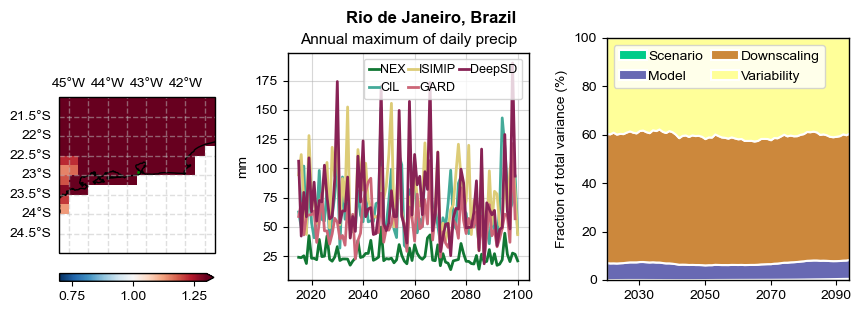

In [24]:
# Setup
city = "rio"
fs = 10
plt.rcParams["font.size"] = fs

# Figure
fig = plt.figure(constrained_layout=True, figsize=(8.5, 3))
subfigs = fig.subfigures(1, 3, wspace=0.05, width_ratios=[0.7, 1, 1])
fig.suptitle("Rio de Janeiro, Brazil", fontweight="bold")

# Maps
axs = subfigs[0].subplots(
    1,
    1,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=dict(hspace=0.2),
)

obs_gridpoint_comparison(
    lat=city_list[city][0],
    lon=city_list[city][1],
    var_id="pr_q99",
    markercolor="g",
    title="",
    cbar=True,
    fs=fs,
    ax=axs,
)

# Timeseries
axs = subfigs[1].subplots(
    1,
    1,
    sharex=True,
    gridspec_kw=dict(hspace=0.2),
)

single_model_plot(
    lat=city_list[city][0],
    lon=city_list[city][1],
    metric="max",
    var_id="pr",
    legend=True,
    title="Annual maximum of daily precip",
    ylabel="mm",
    fs=fs,
    ax=axs,
)

# Full UC
axs = subfigs[2].subplots(
    1,
    1,
    sharex=True,
    gridspec_kw=dict(hspace=0.2),
)

deg = 4
scenario_id = "hs09"
const_iav = False

plot_uc_timeseries(
    metric="max",
    var_id="pr",
    region=[city_list[city][0], city_list[city][1]],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    ylabel="Fraction of total variance (%)",
    xlabel="",
    legend=True,
    fig_label=False,
    fig_label_height=0,
    ax=axs,
)

plt.savefig("../figs/SI_rio_pr_max_comparison.png", dpi=600)

# Interaction effects

In [15]:
################
# Cities
################
city_list = {
    "chicago": [41.881944, -87.627778],
    "lagos": [6.455027, 3.384082],
    "cairo": [30.044444, 31.235833],
    "seattle": [47.609722, -122.333056],
    "delhi": [28.613895, 77.209006],
    "delhiP": [27.125, 76.625],
    "houston": [29.762778, -95.383056],
    "mexicocity": [19.433333, -99.133333],
    "denver": [39.7392, -104.985],
    "nyc": [40.712778, -74.006111],
    "mumbai": [19.076111, 72.8775],
    "jakarta": [-6.175, 106.8275],
    "sanfrancisco": [37.7775, -122.416389],
    "rio": [-22.911111, -43.205556],
    "capetown": [33.925278, 18.423889],
}

In [12]:
##################################
# UC timeseries with interactions
##################################
def plot_uc_anova_timeseries(metric, var_id, city, deg, title, ylabel, xlabel, legend, ax):
    """
    get_timeseries_latlon should have already been run, and ANOVA calculation should have already been
    done in R.
    """
    # Read ANOVA results
    df_anova = pd.read_csv(
        data_path + "anova_results/" + city + "_" + metric + "_" + var_id + "_forced_deg" + str(deg) + ".csv"
    )

    # Read raw and forced (for IAV calculation)
    df_raw = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
    df_forced = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + "_forced_deg" + str(deg) + ".csv")

    # Calculate IAV sum-of-squares
    df_raw = df_raw.rename(columns={var_id: var_id + "_raw"})
    df_forced = df_forced.rename(columns={var_id: var_id + "_forced"})

    df = pd.merge(df_raw, df_forced, on=["time", "ssp", "ensemble", "model"], how="inner")
    df["variability"] = (df[var_id + "_raw"] - df[var_id + "_forced"]) ** 2
    df = df.groupby("time")[["variability"]].sum()

    # Merge
    df = pd.merge(df, df_anova, left_on="time", right_on="year", how="inner")

    # Get fractions
    df["total"] = df.apply(
        lambda x: x["variability"]
        + x["ssp"]
        + x["model"]
        + x["ensemble"]
        + x["ssp_model"]
        + x["model_ensemble"]
        + x["ssp_ensemble"],
        axis=1,
    )

    for uncertainty in [
        "variability",
        "ssp",
        "model",
        "ensemble",
        "ssp_model",
        "model_ensemble",
        "ssp_ensemble",
    ]:
        df[uncertainty] = 100 * df[uncertainty] / df["total"]

    df = df.sort_values(by="year")

    # Construct plotting dict
    uncert_dict = {
        "Scenario": df["ssp"].to_numpy(),
        "Model": df["model"].to_numpy(),
        "Downscaling": df["ensemble"].to_numpy(),
        "Variability": df["variability"].to_numpy(),
        "Model:Downscaling": df["model_ensemble"].to_numpy(),
        "Scenario:Downscaling": df["ssp_ensemble"].to_numpy(),
        "Scenario:Model": df["ssp_model"].to_numpy(),
    }

    # Make plot
    ax.stackplot(
        np.arange(2015, 2101),
        uncert_dict.values(),
        labels=uncert_dict.keys(),
        alpha=1,
        colors=["#00CC89", "#6869B3", "#CC883C", "#FFFF99", "#9a7978", "#a6a95e", "#349b9e"],
        edgecolor="white",
        lw=1,
    )

    if legend:
        ax.legend(loc="center left", ncol=2, columnspacing=0.6, handletextpad=0.1, fontsize=10)

    ax.set_xlim([2015, 2099])
    ax.set_xticks([2030, 2050, 2070, 2090])
    ax.set_ylim([0, 100])
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title, fontsize=11, loc="center")

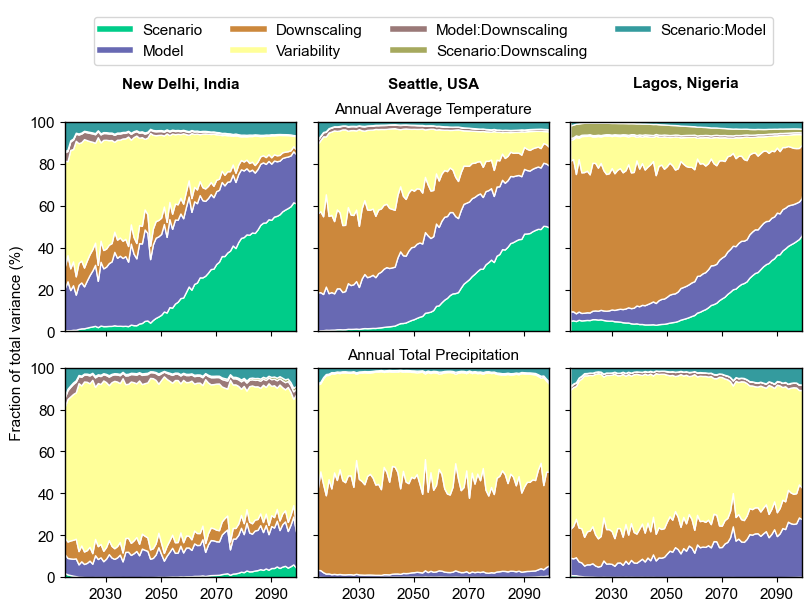

In [13]:
###########################################
# Reproduce Figure 1 with interactions
###########################################
fig, axs = plt.subplots(
    nrows=4,
    ncols=3,
    figsize=(8, 6),
    constrained_layout=True,
    sharey=True,
    sharex=True,
    gridspec_kw={"height_ratios": [2, 1, 10, 10]},
)

# Setup
plt.rcParams["font.size"] = 11
deg = 4
scenario_id = "hs09"
const_iav = False

# Cities
data_path = "/storage/home/dcl5300/work/lafferty-sriver_inprep_tbd/data/"
city1 = "delhi"
city2 = "seattle"
city3 = "lagos"

# Legend
axs[0, 0].remove()
axs[0, 1].remove()
axs[0, 2].remove()

gs = axs[0, 2].get_gridspec()
axlong = fig.add_subplot(gs[0, :])
axlong.axis("off")

colors = ["#00CC89", "#6869B3", "#CC883C", "#FFFF99", "#9a7978", "#a6a95e", "#349b9e"]

custom_lines = [
    Line2D([0], [0], color=colors[0], lw=4),
    Line2D([0], [0], color=colors[1], lw=4),
    Line2D([0], [0], color=colors[2], lw=4),
    Line2D([0], [0], color=colors[3], lw=4),
    Line2D([0], [0], color=colors[4], lw=4),
    Line2D([0], [0], color=colors[5], lw=4),
    Line2D([0], [0], color=colors[6], lw=4),
]

axlong.legend(
    custom_lines,
    [
        "Scenario",
        "Model",
        "Downscaling",
        "Variability",
        "Model:Downscaling",
        "Scenario:Downscaling",
        "Scenario:Model",
    ],
    ncol=4,
    loc="upper center",
)


# Labels
left, width = 0.25, 0.5
bottom, height = 0.25, 0.5
right = left + width
top = bottom + height

axs[1, 0].text(
    x=0.5 * (left + right),
    y=0.5 * (bottom + top),
    s="New Delhi, India",
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 0].transAxes,
    fontweight="bold",
    fontsize=11,
)
axs[1, 0].axis("off")

axs[1, 1].text(
    x=0.5 * (left + right),
    y=0.5 * (bottom + top),
    s="Seattle, USA",
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 1].transAxes,
    fontweight="bold",
    fontsize=11,
)
axs[1, 1].axis("off")

axs[1, 2].text(
    x=0.5 * (left + right),
    y=0.5 * (bottom + top),
    s="Lagos, Nigeria",
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 2].transAxes,
    fontweight="bold",
    fontsize=11,
)
axs[1, 2].axis("off")

# Tas avg
plot_uc_anova_timeseries(
    metric="avg",
    var_id="tas",
    city=city1,
    deg=deg,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    ax=axs[2, 0],
)
axs[2, 0].set_yticks([0, 20, 40, 60, 80, 100])
plot_uc_anova_timeseries(
    metric="avg",
    var_id="tas",
    city=city2,
    deg=deg,
    title="Annual Average Temperature",
    xlabel="",
    ylabel="",
    legend=False,
    ax=axs[2, 1],
)
plot_uc_anova_timeseries(
    metric="avg",
    var_id="tas",
    city=city3,
    deg=deg,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    ax=axs[2, 2],
)

# Pr avg
plot_uc_anova_timeseries(
    metric="avg",
    var_id="pr",
    city=city1,
    deg=deg,
    title="",
    xlabel="",
    ylabel="\t\t\t\t\t\t\t\t\t\t Fraction of total variance (%)".replace("\t", "      "),
    legend=False,
    ax=axs[3, 0],
)
axs[3, 0].set_yticks([0, 20, 40, 60, 80, 100])
plot_uc_anova_timeseries(
    metric="avg",
    var_id="pr",
    city=city2,
    deg=deg,
    title="Annual Total Precipitation",
    xlabel="",
    ylabel="",
    legend=False,
    ax=axs[3, 1],
)
plot_uc_anova_timeseries(
    metric="avg",
    var_id="pr",
    city=city3,
    deg=deg,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    ax=axs[3, 2],
)

plt.savefig("../figs/SI_averages_anova.png", dpi=600)

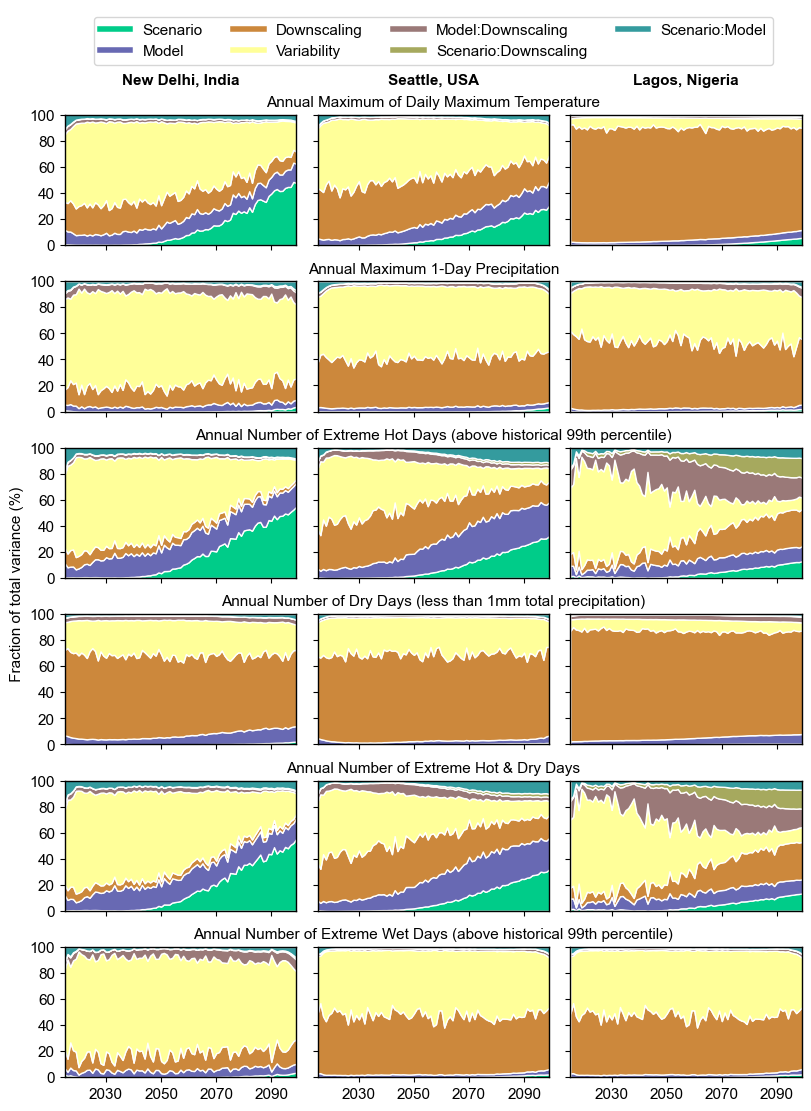

In [16]:
###########################################
# Reproduce Figure 4 with interactions
###########################################
fig, axs = plt.subplots(
    nrows=8,
    ncols=3,
    figsize=(8, 11),
    constrained_layout=True,
    sharey=True,
    sharex=True,
    gridspec_kw={"height_ratios": [2, 1, 10, 10, 10, 10, 10, 10]},
)

# Setup
plt.rcParams["font.size"] = 11
deg = 4
scenario_id = "hs09"
const_iav = False

# Cities
data_path = "/storage/home/dcl5300/work/lafferty-sriver_inprep_tbd/data/"
city1 = "delhiP"
city2 = "seattle"
city3 = "lagos"

# Legend
axs[0, 0].remove()
axs[0, 1].remove()
axs[0, 2].remove()

gs = axs[0, 2].get_gridspec()
axlong = fig.add_subplot(gs[0, :])
axlong.axis("off")

colors = ["#00CC89", "#6869B3", "#CC883C", "#FFFF99", "#9a7978", "#a6a95e", "#349b9e"]

custom_lines = [
    Line2D([0], [0], color=colors[0], lw=4),
    Line2D([0], [0], color=colors[1], lw=4),
    Line2D([0], [0], color=colors[2], lw=4),
    Line2D([0], [0], color=colors[3], lw=4),
    Line2D([0], [0], color=colors[4], lw=4),
    Line2D([0], [0], color=colors[5], lw=4),
    Line2D([0], [0], color=colors[6], lw=4),
]

axlong.legend(
    custom_lines,
    [
        "Scenario",
        "Model",
        "Downscaling",
        "Variability",
        "Model:Downscaling",
        "Scenario:Downscaling",
        "Scenario:Model",
    ],
    ncol=4,
    loc="upper center",
)


# Labels
left, width = 0.25, 0.5
bottom, height = 0.25, 0.5
right = left + width
top = bottom + height

axs[1, 0].text(
    x=0.5 * (left + right),
    y=0.5 * (bottom + top),
    s="New Delhi, India",
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 0].transAxes,
    fontweight="bold",
    fontsize=11,
)
axs[1, 0].axis("off")

axs[1, 1].text(
    x=0.5 * (left + right),
    y=0.5 * (bottom + top),
    s="Seattle, USA",
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 1].transAxes,
    fontweight="bold",
    fontsize=11,
)
axs[1, 1].axis("off")

axs[1, 2].text(
    x=0.5 * (left + right),
    y=0.5 * (bottom + top),
    s="Lagos, Nigeria",
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 2].transAxes,
    fontweight="bold",
    fontsize=11,
)
axs[1, 2].axis("off")

# Tasmax maxima
plot_uc_anova_timeseries(
    metric="max",
    var_id="tasmax",
    city=city1,
    deg=deg,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    ax=axs[2, 0],
)
axs[2, 0].set_yticks([0, 20, 40, 60, 80, 100])
plot_uc_anova_timeseries(
    metric="max",
    var_id="tasmax",
    city=city2,
    deg=deg,
    title="Annual Maximum of Daily Maximum Temperature",
    xlabel="",
    ylabel="",
    legend=False,
    ax=axs[2, 1],
)
plot_uc_anova_timeseries(
    metric="max",
    var_id="tasmax",
    city=city3,
    deg=deg,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    ax=axs[2, 2],
)

# Pr maxima
plot_uc_anova_timeseries(
    metric="max",
    var_id="pr",
    city=city1,
    deg=deg,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    ax=axs[3, 0],
)
axs[3, 0].set_yticks([0, 20, 40, 60, 80, 100])
plot_uc_anova_timeseries(
    metric="max",
    var_id="pr",
    city=city2,
    deg=deg,
    title="Annual Maximum 1-Day Precipitation",
    xlabel="",
    ylabel="",
    legend=False,
    ax=axs[3, 1],
)
plot_uc_anova_timeseries(
    metric="max",
    var_id="pr",
    city=city3,
    deg=deg,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    ax=axs[3, 2],
)

# Extreme Hot Days: count
plot_uc_anova_timeseries(
    metric="hot",
    var_id="tasmax_q99gmfd_count",
    city=city1,
    deg=deg,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    ax=axs[4, 0],
)
axs[4, 0].set_yticks([0, 20, 40, 60, 80, 100])
plot_uc_anova_timeseries(
    metric="hot",
    var_id="tasmax_q99gmfd_count",
    city=city2,
    deg=deg,
    title="Annual Number of Extreme Hot Days (above historical 99th percentile)",
    xlabel="",
    ylabel="",
    legend=False,
    ax=axs[4, 1],
)
plot_uc_anova_timeseries(
    metric="hot",
    var_id="tasmax_q99gmfd_count",
    city=city3,
    deg=deg,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    ax=axs[4, 2],
)

# Dry days: count
plot_uc_anova_timeseries(
    metric="dry",
    var_id="count_lt_1",
    city=city1,
    deg=deg,
    title="",
    ylabel="\t\t\t\t\t\t\t\t\t\t\t Fraction of total variance (%)".replace("\t", "    "),
    xlabel="",
    legend=False,
    ax=axs[5, 0],
)
plot_uc_anova_timeseries(
    metric="dry",
    var_id="count_lt_1",
    city=city2,
    deg=deg,
    title="Annual Number of Dry Days (less than 1mm total precipitation)",
    xlabel="",
    ylabel="",
    legend=False,
    ax=axs[5, 1],
)
plot_uc_anova_timeseries(
    metric="dry",
    var_id="count_lt_1",
    city=city3,
    deg=deg,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    ax=axs[5, 2],
)

# Extreme Hot & Dry Days: count
plot_uc_anova_timeseries(
    metric="hotdry",
    var_id="hotdry_q99gmfd_count",
    city=city1,
    deg=deg,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    ax=axs[6, 0],
)
plot_uc_anova_timeseries(
    metric="hotdry",
    var_id="hotdry_q99gmfd_count",
    city=city2,
    deg=deg,
    title="Annual Number of Extreme Hot & Dry Days",
    xlabel="",
    ylabel="",
    legend=False,
    ax=axs[6, 1],
)
plot_uc_anova_timeseries(
    metric="hotdry",
    var_id="hotdry_q99gmfd_count",
    city=city3,
    deg=deg,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    ax=axs[6, 2],
)

# Extreme Wet Days: count
plot_uc_anova_timeseries(
    metric="wet",
    var_id="pr_q99gmfd_count",
    city=city1,
    deg=deg,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    ax=axs[7, 0],
)
plot_uc_anova_timeseries(
    metric="wet",
    var_id="pr_q99gmfd_count",
    city=city2,
    deg=deg,
    title="Annual Number of Extreme Wet Days (above historical 99th percentile)",
    xlabel="",
    ylabel="",
    legend=False,
    ax=axs[7, 1],
)
plot_uc_anova_timeseries(
    metric="wet",
    var_id="pr_q99gmfd_count",
    city=city2,
    deg=deg,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    ax=axs[7, 2],
)

plt.savefig("../figs/SI_extremes_anova.png", dpi=600)

# Observational dataset comparison

### Preliminaries

In [ ]:
############
# Dask
############
from dask_jobqueue import PBSCluster

cluster = PBSCluster(
    cores=1,
    memory="15GB",
    resource_spec="pmem=15GB",
    worker_extra_args=["#PBS -l feature=rhel7"],
    walltime="01:00:00",
)

cluster.scale(jobs=40)  # ask for jobs

from dask.distributed import Client

client = Client(cluster)

client

### Computations

In [6]:
%%time
##############
### GMFD
##############
in_path = "/gpfs/group/kaf26/default/rls66/GMFD_25/"
out_path = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/obs_data/annual/gmfd/"

# Read all
ds_tmin = xr.open_mfdataset(in_path + "tmin_daily_*", parallel=True, chunks="auto")
ds_tmin -= 273.15  # K -> C

ds_tmax = xr.open_mfdataset(in_path + "tmax_daily_*", parallel=True, chunks="auto")
ds_tmax -= 273.15  # K -> C

ds_pr = xr.open_mfdataset(in_path + "prcp_daily_*", parallel=True, chunks="auto")
ds_pr *= 86400  # kg m-2 s-1 -> mm/day

# Select time period
ds_tmin = ds_tmin.sel(time=slice("1980-01-01", "2014-12-31"))
ds_tmax = ds_tmax.sel(time=slice("1980-01-01", "2014-12-31"))
ds_pr = ds_pr.sel(time=slice("1980-01-01", "2014-12-31"))

# Get tasavg
ds_tas = (ds_tmin["tmin"] + ds_tmax["tmax"]) / 2.0

# Merge
ds = xr.merge([xr.Dataset({"tas": ds_tas}), ds_tmin, ds_tmax, ds_pr])

# Resample to annual
ds_avg = ds.resample(time="1Y").mean()
ds_max = ds.resample(time="1Y").max()

# Merge and store
ds_out = xr.merge(
    [
        ds_avg.rename(
            {
                "tas": "tas_avg",
                "tmax": "tasmax_avg",
                "tmin": "tasmin_avg",
                "prcp": "pr_avg",
            }
        ),
        ds_max.rename(
            {
                "tas": "tas_max",
                "tmax": "tasmax_max",
                "tmin": "tasmin_max",
                "prcp": "pr_max",
            }
        ),
    ]
)

ds_out["lon"] = np.where(ds_out["lon"] > 180, ds_out["lon"] - 360, ds_out["lon"])  # update lon
ds_out = ds_out.sortby("lon")

ds_out.to_netcdf(out_path + "gmfd_annual.nc")

CPU times: user 2min 14s, sys: 5.7 s, total: 2min 20s
Wall time: 6min 17s


In [3]:
##############
### W5E5 v2.0
##############
in_path = "/gpfs/group/kaf26/default/dcl5300/W5E5v2/"
out_path = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/obs_data/annual/w5e5/"

# Read all
ds_tas = xr.open_mfdataset(in_path + "tas_*.nc", parallel=True, chunks="auto")
ds_tas -= 273.15  # K -> C

ds_tmax = xr.open_mfdataset(in_path + "tasmax_*.nc", parallel=True, chunks="auto")
ds_tmax -= 273.15  # K -> C

ds_tmin = xr.open_mfdataset(in_path + "tasmin_*.nc", parallel=True, chunks="auto")
ds_tmin -= 273.15  # K -> C

ds_pr = xr.open_mfdataset(in_path + "pr_*.nc", parallel=True, chunks="auto")
ds_pr *= 86400  # kg m-2 s-1 -> mm/day

# Select time period
ds_tas = ds_tas.sel(time=slice("1980-01-01", "2014-12-31"))
ds_tmin = ds_tmin.sel(time=slice("1980-01-01", "2014-12-31"))
ds_tmax = ds_tmax.sel(time=slice("1980-01-01", "2014-12-31"))
ds_pr = ds_pr.sel(time=slice("1980-01-01", "2014-12-31"))

# Merge
ds = xr.merge([ds_tas, ds_tmin, ds_tmax, ds_pr])

# Resample to annual
ds_avg = ds.resample(time="1Y").mean()
ds_max = ds.resample(time="1Y").max()

# Merge and store
ds_out = xr.merge(
    [
        ds_avg.rename(
            {
                "tas": "tas_avg",
                "tasmax": "tasmax_avg",
                "tasmin": "tasmin_avg",
                "pr": "pr_avg",
            }
        ),
        ds_max.rename(
            {
                "tas": "tas_max",
                "tasmax": "tasmax_max",
                "tasmin": "tasmin_max",
                "pr": "pr_max",
            }
        ),
    ]
)

ds_out.to_netcdf(out_path + "w5e5_annual.nc")

In [6]:
%%time
##############
### Regridding
##############
read_path = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/obs_data/annual/"

ds_gmfd = xr.open_dataset(read_path + "gmfd/gmfd_annual.nc")
ds_w5e5 = xr.open_dataset(read_path + "w5e5/w5e5_annual.nc")

ds_era5_temp = xr.open_dataset(read_path + "era5/annual/temperature", engine="zarr")
ds_era5_pr = xr.open_dataset(read_path + "era5/annual/precip", engine="zarr")

# Regrid to model metrics
out_grid = xr.open_dataset(
    "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/nex-gddp/avg/ACCESS-ESM1-5.nc"
)

land_mask = out_grid.isel(time=0, ssp=0).tas.isnull().drop(["ssp", "time"])

out_grid = xr.Dataset({"lat": out_grid.lat, "lon": out_grid.lon})

## xESMF conservative regridder
# GMFD
cons_regridder = xe.Regridder(ds_gmfd, out_grid, "conservative", periodic=True)
ds_gmfd_cons = cons_regridder(ds_gmfd)

ds_gmfd_cons = xr.where(land_mask, np.nan, ds_gmfd_cons)

ds_gmfd_cons.to_netcdf(read_path + "gmfd/gmfd_annual_regridded.nc")

# W5E5
cons_regridder = xe.Regridder(ds_w5e5, out_grid, "conservative", periodic=True)
ds_w5e5_cons = cons_regridder(ds_w5e5)

ds_w5e5_cons = xr.where(land_mask, np.nan, ds_w5e5_cons)

ds_w5e5_cons.to_netcdf(read_path + "w5e5/w5e5_annual_regridded.nc")

# ERA5
ds_era5 = xr.merge([ds_era5_temp, ds_era5_pr])

cons_regridder = xe.Regridder(ds_era5, out_grid, "conservative", periodic=True)
ds_era5_cons = cons_regridder(ds_era5)

ds_era5_cons = xr.where(land_mask, np.nan, ds_era5_cons)

ds_era5_cons.to_netcdf(read_path + "era5/era5_annual_regridded.nc")

/storage/work/d/dcl5300/ENVS/micromamba/envs/climate-stack-mamba-2023-01/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


CPU times: user 2min 35s, sys: 6.49 s, total: 2min 41s
Wall time: 2min 47s


## Plots

### Cities

In [2]:
################
# Cities
################
city_list = {
    "chicago": [41.881944, -87.627778],
    "lagos": [6.455027, 3.384082],
    "cairo": [30.044444, 31.235833],
    "seattle": [47.609722, -122.333056],
    "delhi": [28.613895, 77.209006],
    "houston": [29.762778, -95.383056],
    "mexicocity": [19.433333, -99.133333],
    "denver": [39.7392, -104.985],
    "nyc": [40.712778, -74.006111],
}

In [12]:
def fix_lon(ds):
    ds["lon"] = np.where(ds["lon"] > 180, ds["lon"] - 360, ds["lon"])
    return ds.sortby("lon")

In [13]:
# Read all
read_path = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/obs_data/annual/"

ds_gmfd = fix_lon(xr.open_dataset(read_path + "gmfd/gmfd_annual_regridded.nc"))
ds_gmfd = ds_gmfd.assign_coords(obs="GMFD")

ds_w5e5 = fix_lon(xr.open_dataset(read_path + "w5e5/w5e5_annual_regridded.nc"))
ds_w5e5 = ds_w5e5.assign_coords(obs="W5E5")

ds_era5 = fix_lon(xr.open_dataset(read_path + "era5/era5_annual_regridded.nc"))
ds_era5 = ds_era5.assign_coords(obs="ERA5")

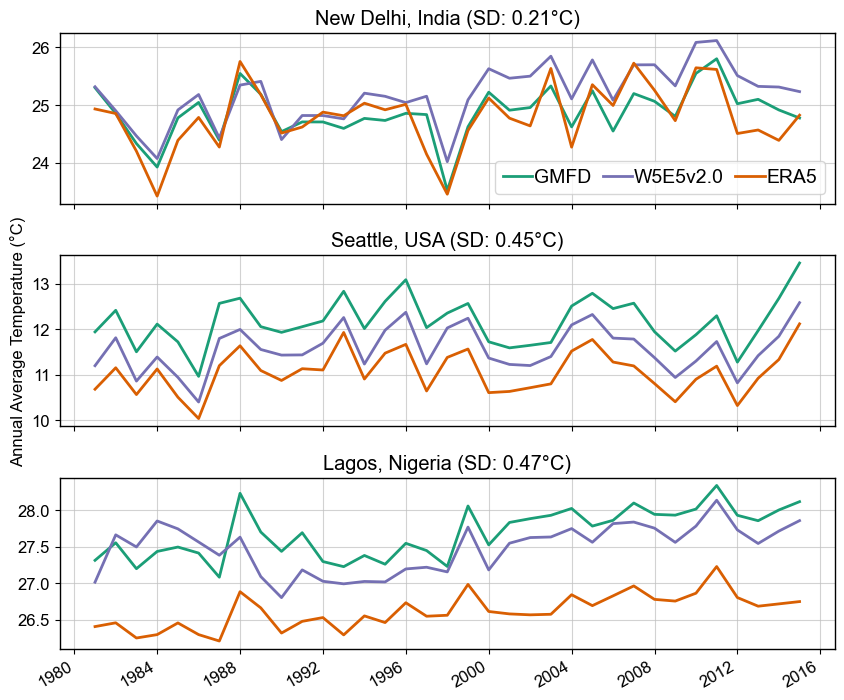

In [17]:
# Figure 1: average temperature
plt.rcParams["font.size"] = 12

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True, sharey=False, gridspec_kw={"hspace": 0.3})

color_dict = {"GMFD": "#1b9e77", "ERA5": "#d95f02", "W5E5": "#7570b3"}

### New Delhi, India
ax = axs[0]
lat, lon = city_list["delhi"]
ds_gmfd.sel(lat=lat, lon=lon, method="nearest").tas_avg.plot(ax=ax, label=None, lw=2, color=color_dict["GMFD"])
ds_w5e5.sel(lat=lat, lon=lon, method="nearest").tas_avg.plot(ax=ax, label=None, lw=2, color=color_dict["W5E5"])
ds_era5.sel(lat=lat, lon=lon, method="nearest").tas_avg.plot(ax=ax, label=None, lw=2, color=color_dict["ERA5"])

# SD calculation
sd = (
    xr.concat(
        [
            ds_gmfd.sel(lat=lat, lon=lon, method="nearest").tas_avg,
            ds_w5e5.sel(lat=lat, lon=lon, method="nearest").tas_avg,
            ds_era5.sel(lat=lat, lon=lon, method="nearest").tas_avg,
        ],
        dim="obs",
    )
    .std(dim="obs")
    .mean(dim="time")
)
ax.set_title("New Delhi, India (SD: {sd:.2f}".format(sd=sd) + "\N{DEGREE SIGN}C)")

ax.set_xlabel("")
ax.grid(color="silver", alpha=0.7)
ax.set_ylabel("")

ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] * 1)
ax.set_xlim(ax.get_xlim())
ax.plot([100, 200], [100, 200], color=color_dict["GMFD"], lw=2, label="GMFD")
ax.plot([100, 200], [100, 200], color=color_dict["W5E5"], lw=2, label="W5E5v2.0")
ax.plot([100, 200], [100, 200], color=color_dict["ERA5"], lw=2, label="ERA5")
ax.legend(fontsize=14, ncols=3, columnspacing=0.6, handletextpad=0.1, handlelength=1.5)

### Seattle, USA
ax = axs[1]
lat, lon = city_list["seattle"]
ds_gmfd.sel(lat=lat, lon=lon, method="nearest").tas_avg.plot(ax=ax, label=None, lw=2, color=color_dict["GMFD"])
ds_w5e5.sel(lat=lat, lon=lon, method="nearest").tas_avg.plot(ax=ax, label=None, lw=2, color=color_dict["W5E5"])
ds_era5.sel(lat=lat, lon=lon, method="nearest").tas_avg.plot(ax=ax, label=None, lw=2, color=color_dict["ERA5"])

# SD calculation
sd = (
    xr.concat(
        [
            ds_gmfd.sel(lat=lat, lon=lon, method="nearest").tas_avg,
            ds_w5e5.sel(lat=lat, lon=lon, method="nearest").tas_avg,
            ds_era5.sel(lat=lat, lon=lon, method="nearest").tas_avg,
        ],
        dim="obs",
    )
    .std(dim="obs")
    .mean(dim="time")
)
ax.set_title("Seattle, USA (SD: {sd:.2f}".format(sd=sd) + "\N{DEGREE SIGN}C)")

ax.set_xlabel("")
ax.grid(color="silver", alpha=0.7)
ax.set_ylabel("Annual Average Temperature " + "(\N{DEGREE SIGN}C)")


### Lagos, Nigeria
ax = axs[2]
lat, lon = city_list["lagos"]
ds_gmfd.sel(lat=lat, lon=lon, method="nearest").tas_avg.plot(ax=ax, label=None, lw=2, color=color_dict["GMFD"])
ds_w5e5.sel(lat=lat, lon=lon, method="nearest").tas_avg.plot(ax=ax, label=None, lw=2, color=color_dict["W5E5"])
ds_era5.sel(lat=lat, lon=lon, method="nearest").tas_avg.plot(ax=ax, label=None, lw=2, color=color_dict["ERA5"])

# SD calculation
sd = (
    xr.concat(
        [
            ds_gmfd.sel(lat=lat, lon=lon, method="nearest").tas_avg,
            ds_w5e5.sel(lat=lat, lon=lon, method="nearest").tas_avg,
            ds_era5.sel(lat=lat, lon=lon, method="nearest").tas_avg,
        ],
        dim="obs",
    )
    .std(dim="obs")
    .mean(dim="time")
)
ax.set_title("Lagos, Nigeria (SD: {sd:.2f}".format(sd=sd) + "\N{DEGREE SIGN}C)")

ax.set_xlabel("")
ax.grid(color="silver", alpha=0.7)
ax.set_ylabel("")

plt.savefig("../figs/SI_city_obs_tas_avg_comparison.png", dpi=600)

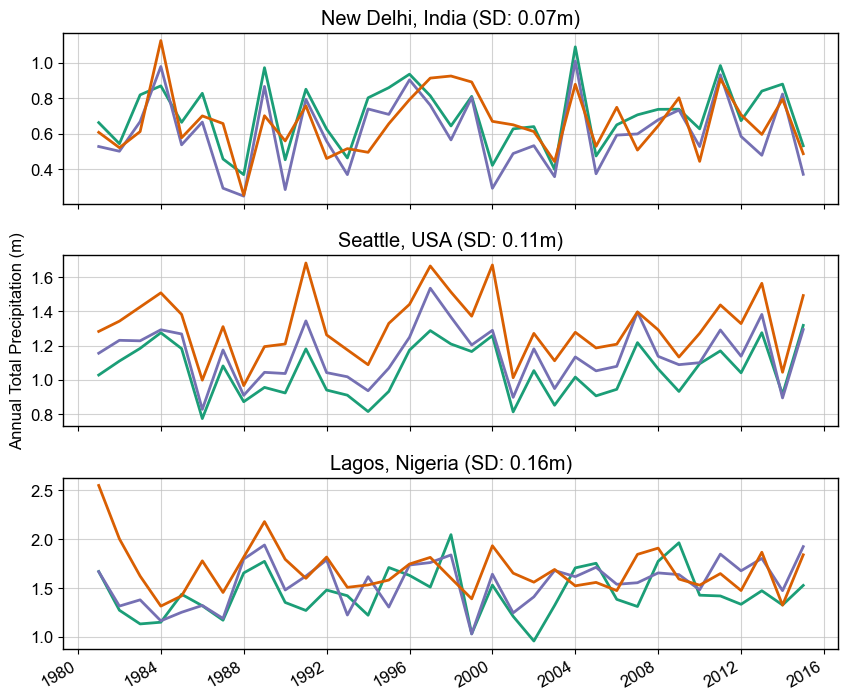

In [18]:
# Figure 2: average precip
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True, sharey=False, gridspec_kw={"hspace": 0.3})

color_dict = {"GMFD": "#1b9e77", "ERA5": "#d95f02", "W5E5": "#7570b3"}

### New Delhi, India
ax = axs[0]
lat, lon = city_list["delhi"]
(ds_gmfd.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000).plot(
    ax=ax, label=None, lw=2, color=color_dict["GMFD"]
)
(ds_w5e5.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000).plot(
    ax=ax, label=None, lw=2, color=color_dict["W5E5"]
)
(ds_era5.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000).plot(
    ax=ax, label=None, lw=2, color=color_dict["ERA5"]
)
# SD calculation
sd = (
    xr.concat(
        [
            ds_gmfd.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000,
            ds_w5e5.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000,
            ds_era5.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000,
        ],
        dim="obs",
    )
    .std(dim="obs")
    .mean(dim="time")
)
ax.set_title("New Delhi, India (SD: {sd:.2f}m)".format(sd=sd))
ax.set_xlabel("")
ax.grid(color="silver", alpha=0.7)
ax.set_ylabel("")

### Seattle, USA
ax = axs[1]
lat, lon = city_list["seattle"]
(ds_gmfd.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000).plot(
    ax=ax, label=None, lw=2, color=color_dict["GMFD"]
)
(ds_w5e5.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000).plot(
    ax=ax, label=None, lw=2, color=color_dict["W5E5"]
)
(ds_era5.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000).plot(
    ax=ax, label=None, lw=2, color=color_dict["ERA5"]
)
# SD calculation
sd = (
    xr.concat(
        [
            ds_gmfd.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000,
            ds_w5e5.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000,
            ds_era5.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000,
        ],
        dim="obs",
    )
    .std(dim="obs")
    .mean(dim="time")
)
ax.set_title("Seattle, USA (SD: {sd:.2f}m)".format(sd=sd))
ax.set_xlabel("")
ax.grid(color="silver", alpha=0.7)
ax.set_ylabel("Annual Total Precipitation (m)")

### Lagos, Nigeria
ax = axs[2]
lat, lon = city_list["lagos"]
(ds_gmfd.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000).plot(
    ax=ax, label=None, lw=2, color=color_dict["GMFD"]
)
(ds_w5e5.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000).plot(
    ax=ax, label=None, lw=2, color=color_dict["W5E5"]
)
(ds_era5.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000).plot(
    ax=ax, label=None, lw=2, color=color_dict["ERA5"]
)
# SD calculation
sd = (
    xr.concat(
        [
            ds_gmfd.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000,
            ds_w5e5.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000,
            ds_era5.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000,
        ],
        dim="obs",
    )
    .std(dim="obs")
    .mean(dim="time")
)
ax.set_title("Lagos, Nigeria (SD: {sd:.2f}m)".format(sd=sd))
ax.set_xlabel("")
ax.grid(color="silver", alpha=0.7)
ax.set_ylabel("")

plt.savefig("../figs/SI_city_obs_pr_avg_comparison.png", dpi=600)

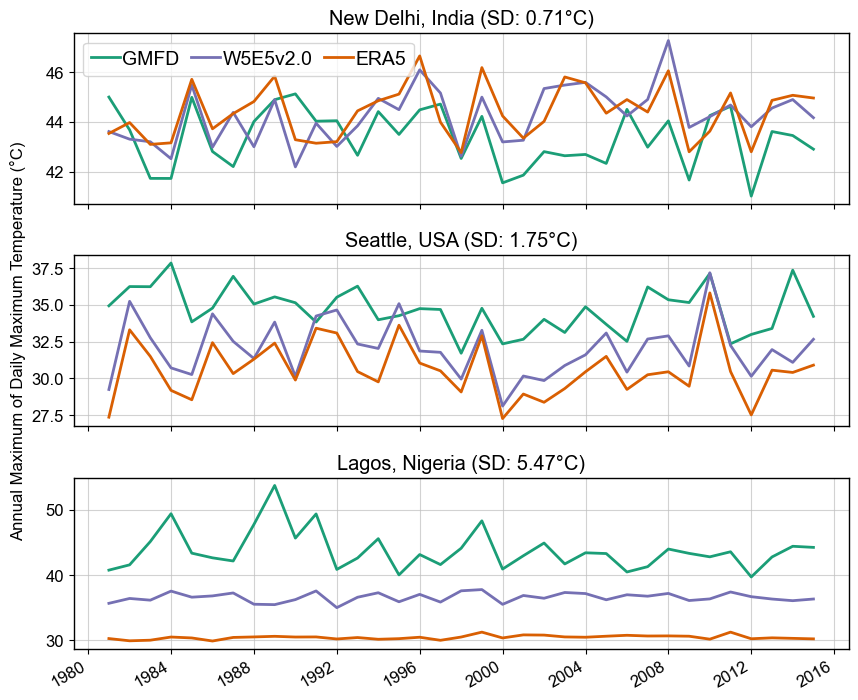

In [20]:
# Figure 3: maximum temperature
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True, sharey=False, gridspec_kw={"hspace": 0.3})

color_dict = {"GMFD": "#1b9e77", "ERA5": "#d95f02", "W5E5": "#7570b3"}

### New Delhi, India
ax = axs[0]
lat, lon = city_list["delhi"]
ds_gmfd.sel(lat=lat, lon=lon, method="nearest").tasmax_max.plot(ax=ax, label=None, lw=2, color=color_dict["GMFD"])
ds_w5e5.sel(lat=lat, lon=lon, method="nearest").tasmax_max.plot(ax=ax, label=None, lw=2, color=color_dict["W5E5"])
ds_era5.sel(lat=lat, lon=lon, method="nearest").tasmax_max.plot(ax=ax, label=None, lw=2, color=color_dict["ERA5"])

# SD calculation
sd = (
    xr.concat(
        [
            ds_gmfd.sel(lat=lat, lon=lon, method="nearest").tasmax_max,
            ds_w5e5.sel(lat=lat, lon=lon, method="nearest").tasmax_max,
            ds_era5.sel(lat=lat, lon=lon, method="nearest").tasmax_max,
        ],
        dim="obs",
    )
    .std(dim="obs")
    .mean(dim="time")
)
ax.set_title("New Delhi, India (SD: {sd:.2f}".format(sd=sd) + "\N{DEGREE SIGN}C)")

ax.set_xlabel("")
ax.grid(color="silver", alpha=0.7)
ax.set_ylabel("")

ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] * 1)
ax.set_xlim(ax.get_xlim())
ax.plot([100, 200], [100, 200], color=color_dict["GMFD"], lw=2, label="GMFD")
ax.plot([100, 200], [100, 200], color=color_dict["W5E5"], lw=2, label="W5E5v2.0")
ax.plot([100, 200], [100, 200], color=color_dict["ERA5"], lw=2, label="ERA5")
ax.legend(fontsize=14, ncols=3, columnspacing=0.6, handletextpad=0.1, handlelength=1.5)

### Seattle, USA
ax = axs[1]
lat, lon = city_list["seattle"]
ds_gmfd.sel(lat=lat, lon=lon, method="nearest").tasmax_max.plot(ax=ax, label=None, lw=2, color=color_dict["GMFD"])
ds_w5e5.sel(lat=lat, lon=lon, method="nearest").tasmax_max.plot(ax=ax, label=None, lw=2, color=color_dict["W5E5"])
ds_era5.sel(lat=lat, lon=lon, method="nearest").tasmax_max.plot(ax=ax, label=None, lw=2, color=color_dict["ERA5"])

# SD calculation
sd = (
    xr.concat(
        [
            ds_gmfd.sel(lat=lat, lon=lon, method="nearest").tasmax_max,
            ds_w5e5.sel(lat=lat, lon=lon, method="nearest").tasmax_max,
            ds_era5.sel(lat=lat, lon=lon, method="nearest").tasmax_max,
        ],
        dim="obs",
    )
    .std(dim="obs")
    .mean(dim="time")
)
ax.set_title("Seattle, USA (SD: {sd:.2f}".format(sd=sd) + "\N{DEGREE SIGN}C)")

ax.set_xlabel("")
ax.grid(color="silver", alpha=0.7)
ax.set_ylabel("Annual Maximum of Daily Maximum Temperature " + "(\N{DEGREE SIGN}C)")


### Lagos, Nigeria
ax = axs[2]
lat, lon = city_list["lagos"]
ds_gmfd.sel(lat=lat, lon=lon, method="nearest").tasmax_max.plot(ax=ax, label=None, lw=2, color=color_dict["GMFD"])
ds_w5e5.sel(lat=lat, lon=lon, method="nearest").tasmax_max.plot(ax=ax, label=None, lw=2, color=color_dict["W5E5"])
ds_era5.sel(lat=lat, lon=lon, method="nearest").tasmax_max.plot(ax=ax, label=None, lw=2, color=color_dict["ERA5"])

# SD calculation
sd = (
    xr.concat(
        [
            ds_gmfd.sel(lat=lat, lon=lon, method="nearest").tasmax_max,
            ds_w5e5.sel(lat=lat, lon=lon, method="nearest").tasmax_max,
            ds_era5.sel(lat=lat, lon=lon, method="nearest").tasmax_max,
        ],
        dim="obs",
    )
    .std(dim="obs")
    .mean(dim="time")
)
ax.set_title("Lagos, Nigeria (SD: {sd:.2f}".format(sd=sd) + "\N{DEGREE SIGN}C)")

ax.set_xlabel("")
ax.grid(color="silver", alpha=0.7)
ax.set_ylabel("")

plt.savefig("../figs/SI_city_obs_tasmax_max_comparison.png", dpi=600)

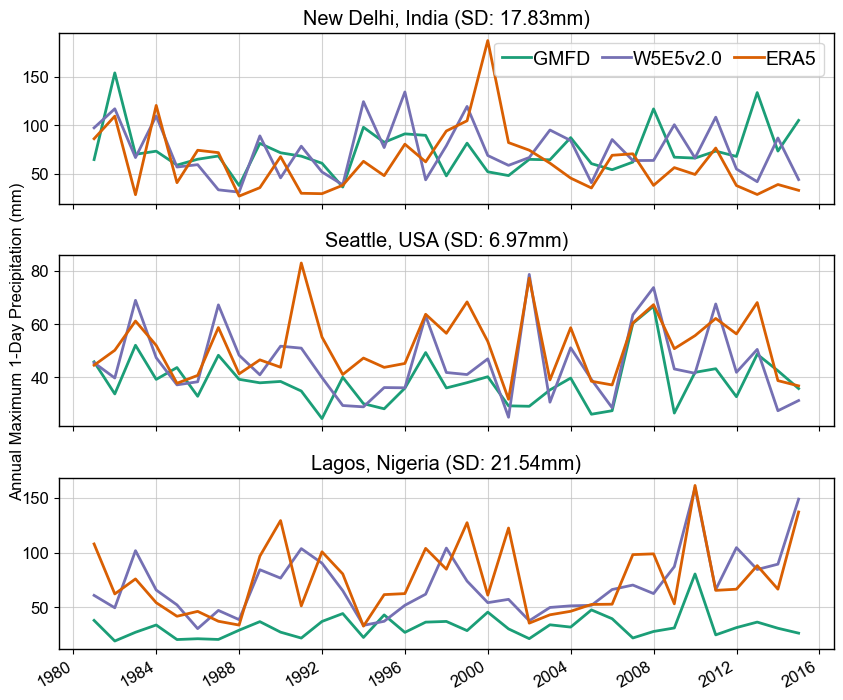

In [22]:
# Figure 3: maximum temperature
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True, sharey=False, gridspec_kw={"hspace": 0.3})

color_dict = {"GMFD": "#1b9e77", "ERA5": "#d95f02", "W5E5": "#7570b3"}

### New Delhi, India
ax = axs[0]
lat, lon = city_list["delhi"]
ds_gmfd.sel(lat=lat, lon=lon, method="nearest").pr_max.plot(ax=ax, label=None, lw=2, color=color_dict["GMFD"])
ds_w5e5.sel(lat=lat, lon=lon, method="nearest").pr_max.plot(ax=ax, label=None, lw=2, color=color_dict["W5E5"])
ds_era5.sel(lat=lat, lon=lon, method="nearest").pr_max.plot(ax=ax, label=None, lw=2, color=color_dict["ERA5"])

# SD calculation
sd = (
    xr.concat(
        [
            ds_gmfd.sel(lat=lat, lon=lon, method="nearest").pr_max,
            ds_w5e5.sel(lat=lat, lon=lon, method="nearest").pr_max,
            ds_era5.sel(lat=lat, lon=lon, method="nearest").pr_max,
        ],
        dim="obs",
    )
    .std(dim="obs")
    .mean(dim="time")
)
ax.set_title("New Delhi, India (SD: {sd:.2f}".format(sd=sd) + "mm)")

ax.set_xlabel("")
ax.grid(color="silver", alpha=0.7)
ax.set_ylabel("")

ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] * 1)
ax.set_xlim(ax.get_xlim())
ax.plot([100, 200], [100, 200], color=color_dict["GMFD"], lw=2, label="GMFD")
ax.plot([100, 200], [100, 200], color=color_dict["W5E5"], lw=2, label="W5E5v2.0")
ax.plot([100, 200], [100, 200], color=color_dict["ERA5"], lw=2, label="ERA5")
ax.legend(fontsize=14, ncols=3, columnspacing=0.6, handletextpad=0.1, handlelength=1.5)

### Seattle, USA
ax = axs[1]
lat, lon = city_list["seattle"]
ds_gmfd.sel(lat=lat, lon=lon, method="nearest").pr_max.plot(ax=ax, label=None, lw=2, color=color_dict["GMFD"])
ds_w5e5.sel(lat=lat, lon=lon, method="nearest").pr_max.plot(ax=ax, label=None, lw=2, color=color_dict["W5E5"])
ds_era5.sel(lat=lat, lon=lon, method="nearest").pr_max.plot(ax=ax, label=None, lw=2, color=color_dict["ERA5"])

# SD calculation
sd = (
    xr.concat(
        [
            ds_gmfd.sel(lat=lat, lon=lon, method="nearest").pr_max,
            ds_w5e5.sel(lat=lat, lon=lon, method="nearest").pr_max,
            ds_era5.sel(lat=lat, lon=lon, method="nearest").pr_max,
        ],
        dim="obs",
    )
    .std(dim="obs")
    .mean(dim="time")
)
ax.set_title("Seattle, USA (SD: {sd:.2f}".format(sd=sd) + "mm)")

ax.set_xlabel("")
ax.grid(color="silver", alpha=0.7)
ax.set_ylabel("Annual Maximum 1-Day Precipitation (mm)")


### Lagos, Nigeria
ax = axs[2]
lat, lon = city_list["lagos"]
ds_gmfd.sel(lat=lat, lon=lon, method="nearest").pr_max.plot(ax=ax, label=None, lw=2, color=color_dict["GMFD"])
ds_w5e5.sel(lat=lat, lon=lon, method="nearest").pr_max.plot(ax=ax, label=None, lw=2, color=color_dict["W5E5"])
ds_era5.sel(lat=lat, lon=lon, method="nearest").pr_max.plot(ax=ax, label=None, lw=2, color=color_dict["ERA5"])

# SD calculation
sd = (
    xr.concat(
        [
            ds_gmfd.sel(lat=lat, lon=lon, method="nearest").pr_max,
            ds_w5e5.sel(lat=lat, lon=lon, method="nearest").pr_max,
            ds_era5.sel(lat=lat, lon=lon, method="nearest").pr_max,
        ],
        dim="obs",
    )
    .std(dim="obs")
    .mean(dim="time")
)
ax.set_title("Lagos, Nigeria (SD: {sd:.2f}".format(sd=sd) + "mm)")

ax.set_xlabel("")
ax.grid(color="silver", alpha=0.7)
ax.set_ylabel("")

plt.savefig("../figs/SI_city_obs_pr_max_comparison.png", dpi=600)
plt.show()

### Maps (averages, maxs)

In [ ]:
# Read all
read_path = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/obs_data/annual/"

ds_gmfd = fix_lon(xr.open_dataset(read_path + "gmfd/gmfd_annual_regridded.nc"))
ds_gmfd = ds_gmfd.assign_coords(obs="GMFD")

ds_w5e5 = fix_lon(xr.open_dataset(read_path + "w5e5/w5e5_annual_regridded.nc"))
ds_w5e5 = ds_w5e5.assign_coords(obs="W5E5")

ds_era5 = fix_lon(xr.open_dataset(read_path + "era5/era5_annual_regridded.nc"))
ds_era5 = ds_era5.assign_coords(obs="ERA5")

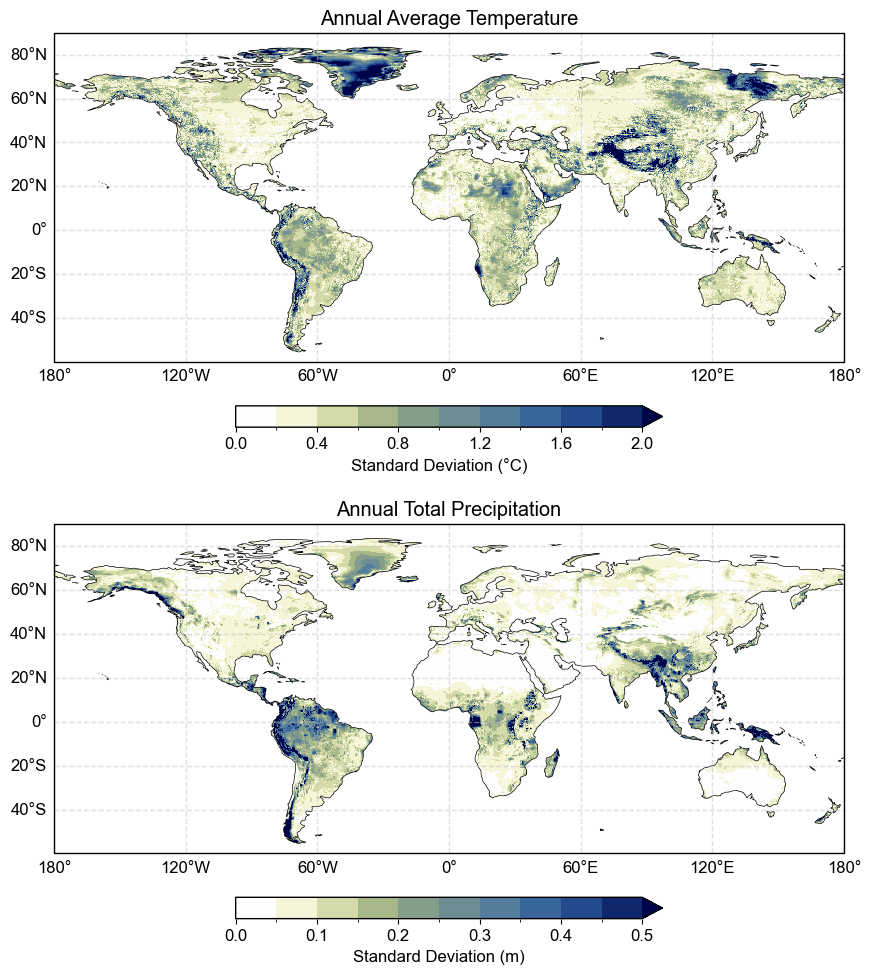

In [23]:
# Map of average SD over time
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(9, 10), subplot_kw=dict(projection=ccrs.PlateCarree()))

## Average temperature map
# Merge
ds_all = xr.concat([ds_gmfd.tas_avg, ds_era5.tas_avg, ds_w5e5.tas_avg], dim="obs")
# Variance across obs, averaged over time
ds_all_std = ds_all.std(dim="obs").mean(dim="time")

ds_all_std.plot(
    ax=axs[0],
    transform=ccrs.PlateCarree(),
    vmin=0.0,
    vmax=2.0,
    zorder=1,
    levels=11,
    cmap=scm_map,
    add_colorbar=True,
    cbar_kwargs={
        "orientation": "horizontal",
        "label": "Standard Deviation " + "(\N{DEGREE SIGN}C)",
        "shrink": 0.5,
        "pad": 0.1,
    },
)
axs[0].set_title("Annual Average Temperature")

## Precipitation map
# Merge
ds_all = xr.concat([ds_gmfd.pr_avg, ds_era5.pr_avg, ds_w5e5.pr_avg], dim="obs")
# Variance across obs, averaged over time
ds_all_std = ds_all.std(dim="obs").mean(dim="time")

(ds_all_std * 365 / 1000).plot(
    ax=axs[1],
    transform=ccrs.PlateCarree(),
    vmin=0.0,
    vmax=0.5,
    cmap=scm_map,
    zorder=1,
    levels=11,
    add_colorbar=True,
    cbar_kwargs={
        "orientation": "horizontal",
        "label": "Standard Deviation (m)",
        "shrink": 0.5,
        "pad": 0.1,
    },
)
axs[1].set_title("Annual Total Precipitation")

for ax in axs:
    ax.add_feature(cfeature.OCEAN, zorder=2, linewidth=0.001, color="white")
    ax.add_feature(cfeature.COASTLINE, linewidth=1.0)
    ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels={"bottom": "x", "left": "y"},
        linewidth=1,
        color="silver",
        alpha=0.5,
        linestyle="--",
    )

plt.tight_layout()
plt.savefig("../figs/SI_map_obs_avg_comparison.png", dpi=600)

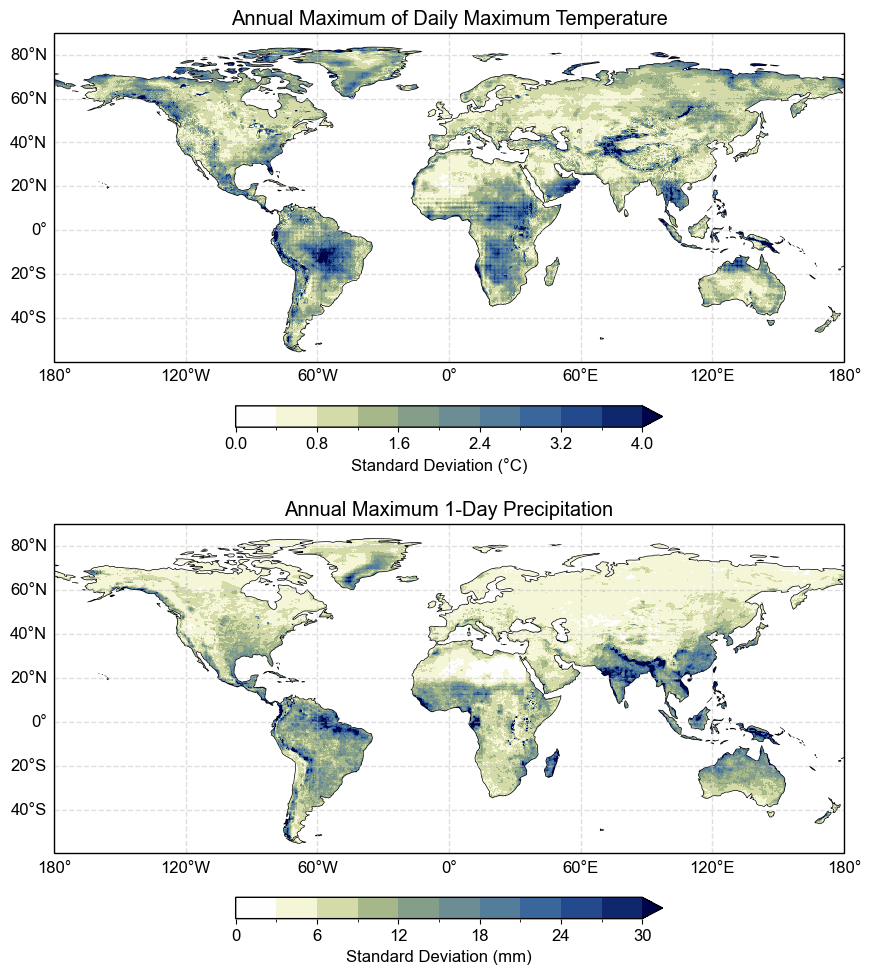

In [27]:
# Map of average SD over time
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(9, 10), subplot_kw=dict(projection=ccrs.PlateCarree()))

## Temperature map
# Merge
ds_all = xr.concat([ds_gmfd.tasmax_max, ds_era5.tasmax_max, ds_w5e5.tasmax_max], dim="obs")
# Variance across obs, averaged over time
ds_all_std = ds_all.std(dim="obs").mean(dim="time")

ds_all_std.plot(
    ax=axs[0],
    transform=ccrs.PlateCarree(),
    vmin=0.0,
    vmax=4.0,
    zorder=1,
    levels=11,
    cmap=scm_map,
    add_colorbar=True,
    cbar_kwargs={
        "orientation": "horizontal",
        "label": "Standard Deviation " + "(\N{DEGREE SIGN}C)",
        "shrink": 0.5,
        "pad": 0.1,
    },
)
axs[0].set_title("Annual Maximum of Daily Maximum Temperature")

## Precipitation map
# Merge
ds_all = xr.concat([ds_gmfd.pr_max, ds_era5.pr_max, ds_w5e5.pr_max], dim="obs")
# Variance across obs, averaged over time
ds_all_std = ds_all.std(dim="obs").mean(dim="time")

ds_all_std.plot(
    ax=axs[1],
    transform=ccrs.PlateCarree(),
    vmin=0.0,
    vmax=30.0,
    cmap=scm_map,
    zorder=1,
    levels=11,
    add_colorbar=True,
    cbar_kwargs={
        "orientation": "horizontal",
        "label": "Standard Deviation (mm)",
        "shrink": 0.5,
        "pad": 0.1,
    },
)
axs[1].set_title("Annual Maximum 1-Day Precipitation")

for ax in axs:
    ax.add_feature(cfeature.OCEAN, zorder=2, linewidth=0.001, color="white")
    ax.add_feature(cfeature.COASTLINE, linewidth=1.0)
    ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels={"bottom": "x", "left": "y"},
        linewidth=1,
        color="silver",
        alpha=0.5,
        linestyle="--",
    )

plt.tight_layout()
plt.savefig("../figs/SI_map_obs_max_comparison.png", dpi=600)

### Maps (quantiles)

In [28]:
# Read all
quantile_path = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/obs_data/quantiles/"

era5_temp = xr.open_dataset(
    quantile_path + "era5_temperature_quantiles_gardsv/",
    engine="zarr",
)
era5_prcp = xr.open_dataset(
    quantile_path + "era5_precip_quantiles_gardsv/",
    engine="zarr",
)

gmfd_temp = xr.open_dataset(quantile_path + "gmfd_temperature_quantiles_gardsv.nc")
gmfd_prcp = xr.open_dataset(quantile_path + "gmfd_precip_quantiles_gardsv.nc")

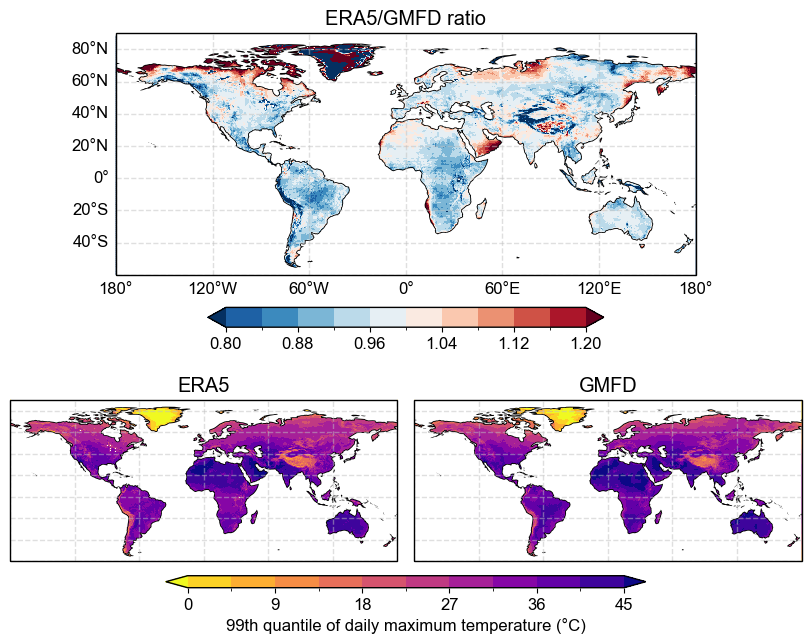

In [33]:
# 99th tasmax temperature quantiles
fig = plt.figure(figsize=(8, 6), layout="constrained")

spec = fig.add_gridspec(2, 2, bottom=0.3, top=0.9, left=0.1, right=0.9, wspace=0.00, hspace=0.01)

# Ratio
ax0 = fig.add_subplot(spec[0, :], projection=ccrs.PlateCarree())
ratio = (era5_temp.tasmax_q99 / gmfd_temp.tasmax_q99).sel(lat=slice(-60, 90))
ratio.plot(
    ax=ax0,
    transform=ccrs.PlateCarree(),
    vmin=0.8,
    vmax=1.2,
    cmap="RdBu_r",
    levels=11,
    zorder=1,
    cbar_kwargs={
        "orientation": "horizontal",
        "label": None,
        "shrink": 0.5,
        "pad": 0.04,
    },
)
ax0.coastlines()
ax0.set_title("ERA5/GMFD ratio")

# ERA5
ax10 = fig.add_subplot(spec[1, 0], projection=ccrs.PlateCarree())
era5_temp.tasmax_q99.sel(lat=slice(-60, 90)).plot(
    ax=ax10,
    transform=ccrs.PlateCarree(),
    levels=11,
    zorder=1,
    add_colorbar=False,
    vmin=0,
    vmax=45,
    cmap="plasma_r",
)
ax10.set_title("ERA5")
ax10.coastlines()

# GMFD
ax11 = fig.add_subplot(spec[1, 1], projection=ccrs.PlateCarree())
p = gmfd_temp.tasmax_q99.sel(lat=slice(-60, 90)).plot(
    ax=ax11,
    transform=ccrs.PlateCarree(),
    levels=11,
    zorder=1,
    add_colorbar=False,
    vmin=0,
    vmax=45,
    cmap="plasma_r",
)

ax11.set_title("GMFD")
ax11.coastlines()

# Add colorbar
cbar_ax = fig.add_axes([0.2, 0.03, 0.6, 0.02])

cbar = fig.colorbar(
    p,
    cax=cbar_ax,
    orientation="horizontal",
    label="99th quantile of daily maximum temperature " + "(\N{DEGREE SIGN}C)",
)

# Gridlines
for ax in [ax10, ax11]:
    ax.add_feature(cfeature.OCEAN, zorder=2, linewidth=0.001, color="white")
    ax.add_feature(cfeature.COASTLINE, linewidth=1.0)
    ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=False,
        linewidth=1,
        color="silver",
        alpha=0.5,
        linestyle="--",
    )


ax0.add_feature(cfeature.OCEAN, zorder=2, linewidth=0.001, color="white")
ax0.add_feature(cfeature.COASTLINE, linewidth=1.0)
ax0.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels={"bottom": "x", "left": "y"},
    linewidth=1,
    color="silver",
    alpha=0.5,
    linestyle="--",
)

plt.savefig("../figs/SI_map_obs_q99_tasmax_comparison.png", dpi=600)

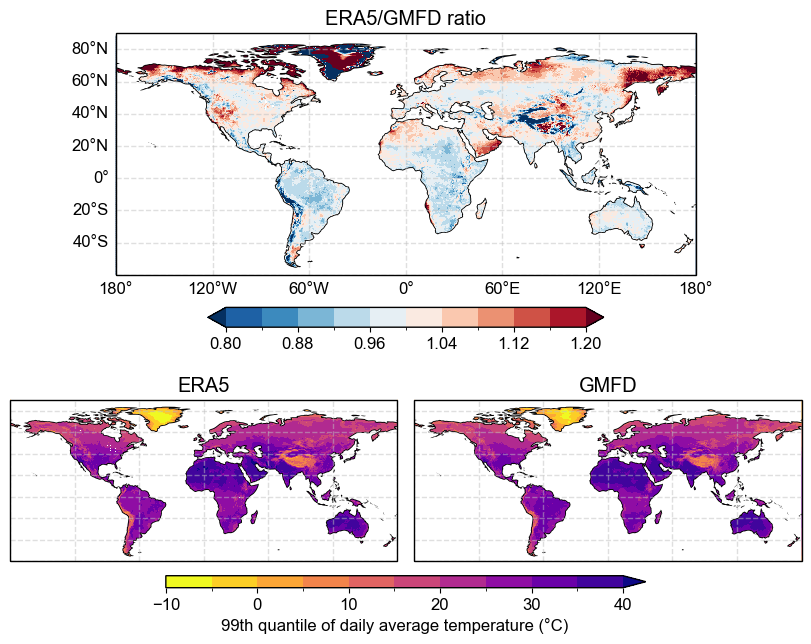

In [41]:
# 99th tasmax temperature quantiles
fig = plt.figure(figsize=(8, 6), layout="constrained")

spec = fig.add_gridspec(2, 2, bottom=0.3, top=0.9, left=0.1, right=0.9, wspace=0.00, hspace=0.01)

# Ratio
ax0 = fig.add_subplot(spec[0, :], projection=ccrs.PlateCarree())
ratio = (era5_temp.tas_q99 / gmfd_temp.tas_q99).sel(lat=slice(-60, 90))
ratio.plot(
    ax=ax0,
    transform=ccrs.PlateCarree(),
    vmin=0.8,
    vmax=1.2,
    cmap="RdBu_r",
    levels=11,
    zorder=1,
    cbar_kwargs={
        "orientation": "horizontal",
        "label": None,
        "shrink": 0.5,
        "pad": 0.04,
    },
)
ax0.coastlines()
ax0.set_title("ERA5/GMFD ratio")

# ERA5
ax10 = fig.add_subplot(spec[1, 0], projection=ccrs.PlateCarree())
era5_temp.tas_q99.sel(lat=slice(-60, 90)).plot(
    ax=ax10,
    transform=ccrs.PlateCarree(),
    levels=11,
    zorder=1,
    add_colorbar=False,
    vmin=-10,
    vmax=40,
    cmap="plasma_r",
)
ax10.set_title("ERA5")
ax10.coastlines()

# GMFD
ax11 = fig.add_subplot(spec[1, 1], projection=ccrs.PlateCarree())
p = gmfd_temp.tas_q99.sel(lat=slice(-60, 90)).plot(
    ax=ax11,
    transform=ccrs.PlateCarree(),
    levels=11,
    zorder=1,
    add_colorbar=False,
    vmin=-10,
    vmax=40,
    cmap="plasma_r",
)

ax11.set_title("GMFD")
ax11.coastlines()

# Add colorbar
cbar_ax = fig.add_axes([0.2, 0.03, 0.6, 0.02])

cbar = fig.colorbar(
    p,
    cax=cbar_ax,
    orientation="horizontal",
    label="99th quantile of daily average temperature " + "(\N{DEGREE SIGN}C)",
)

# Gridlines
for ax in [ax10, ax11]:
    ax.add_feature(cfeature.OCEAN, zorder=2, linewidth=0.001, color="white")
    ax.add_feature(cfeature.COASTLINE, linewidth=1.0)
    ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=False,
        linewidth=1,
        color="silver",
        alpha=0.5,
        linestyle="--",
    )


ax0.add_feature(cfeature.OCEAN, zorder=2, linewidth=0.001, color="white")
ax0.add_feature(cfeature.COASTLINE, linewidth=1.0)
ax0.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels={"bottom": "x", "left": "y"},
    linewidth=1,
    color="silver",
    alpha=0.5,
    linestyle="--",
)

plt.savefig("../figs/SI_map_obs_q99_tas_comparison.png", dpi=600)

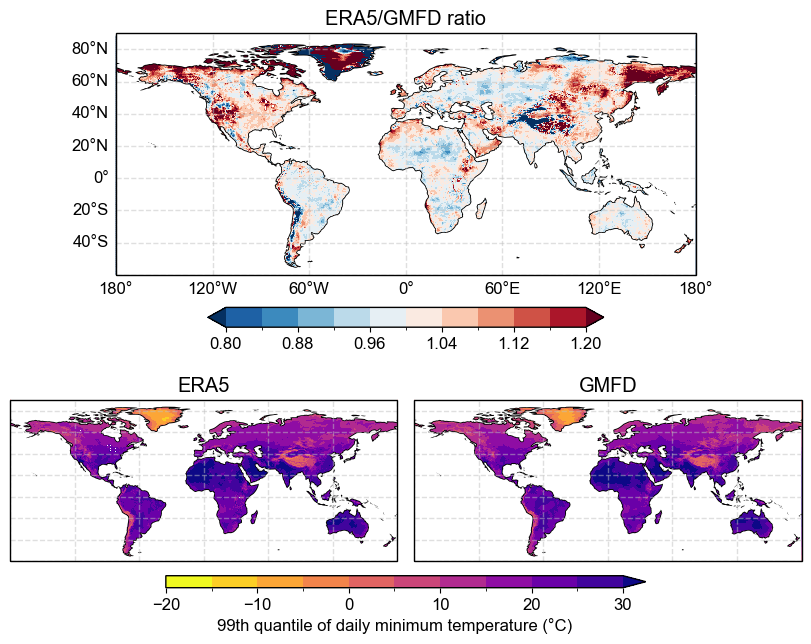

In [42]:
# 99th tasminmax temperature quantiles
fig = plt.figure(figsize=(8, 6), layout="constrained")

spec = fig.add_gridspec(2, 2, bottom=0.3, top=0.9, left=0.1, right=0.9, wspace=0.00, hspace=0.01)

# Ratio
ax0 = fig.add_subplot(spec[0, :], projection=ccrs.PlateCarree())
ratio = (era5_temp.tasmin_q99 / gmfd_temp.tasmin_q99).sel(lat=slice(-60, 90))
ratio.plot(
    ax=ax0,
    transform=ccrs.PlateCarree(),
    vmin=0.8,
    vmax=1.2,
    cmap="RdBu_r",
    levels=11,
    zorder=1,
    cbar_kwargs={
        "orientation": "horizontal",
        "label": None,
        "shrink": 0.5,
        "pad": 0.04,
    },
)
ax0.coastlines()
ax0.set_title("ERA5/GMFD ratio")

# ERA5
ax10 = fig.add_subplot(spec[1, 0], projection=ccrs.PlateCarree())
era5_temp.tasmin_q99.sel(lat=slice(-60, 90)).plot(
    ax=ax10,
    transform=ccrs.PlateCarree(),
    levels=11,
    zorder=1,
    add_colorbar=False,
    vmin=-20,
    vmax=30,
    cmap="plasma_r",
)
ax10.set_title("ERA5")
ax10.coastlines()

# GMFD
ax11 = fig.add_subplot(spec[1, 1], projection=ccrs.PlateCarree())
p = gmfd_temp.tasmin_q99.sel(lat=slice(-60, 90)).plot(
    ax=ax11,
    transform=ccrs.PlateCarree(),
    levels=11,
    zorder=1,
    add_colorbar=False,
    vmin=-20,
    vmax=30,
    cmap="plasma_r",
)

ax11.set_title("GMFD")
ax11.coastlines()

# Add colorbar
cbar_ax = fig.add_axes([0.2, 0.03, 0.6, 0.02])

cbar = fig.colorbar(
    p,
    cax=cbar_ax,
    orientation="horizontal",
    label="99th quantile of daily minimum temperature " + "(\N{DEGREE SIGN}C)",
)

# Gridlines
for ax in [ax10, ax11]:
    ax.add_feature(cfeature.OCEAN, zorder=2, linewidth=0.001, color="white")
    ax.add_feature(cfeature.COASTLINE, linewidth=1.0)
    ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=False,
        linewidth=1,
        color="silver",
        alpha=0.5,
        linestyle="--",
    )


ax0.add_feature(cfeature.OCEAN, zorder=2, linewidth=0.001, color="white")
ax0.add_feature(cfeature.COASTLINE, linewidth=1.0)
ax0.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels={"bottom": "x", "left": "y"},
    linewidth=1,
    color="silver",
    alpha=0.5,
    linestyle="--",
)

plt.savefig("../figs/SI_map_obs_q99_tasmin_comparison.png", dpi=600)

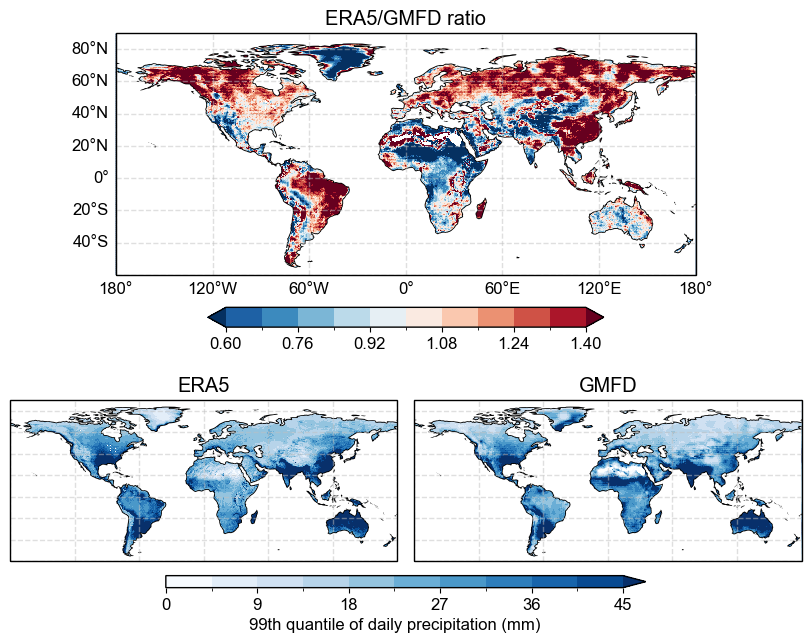

In [36]:
# 99th precip quantiles
fig = plt.figure(figsize=(8, 6), layout="constrained")

spec = fig.add_gridspec(2, 2, bottom=0.3, top=0.9, left=0.1, right=0.9, wspace=0.00, hspace=0.01)

# Ratio
ax0 = fig.add_subplot(spec[0, :], projection=ccrs.PlateCarree())
ratio = (era5_prcp.pr_q99 / gmfd_prcp.pr_q99).sel(lat=slice(-60, 90))
ratio.plot(
    ax=ax0,
    transform=ccrs.PlateCarree(),
    vmin=0.6,
    vmax=1.4,
    cmap="RdBu_r",
    levels=11,
    zorder=1,
    cbar_kwargs={
        "orientation": "horizontal",
        "label": None,
        "shrink": 0.5,
        "pad": 0.04,
    },
)
ax0.coastlines()
ax0.set_title("ERA5/GMFD ratio")

# ERA5
ax10 = fig.add_subplot(spec[1, 0], projection=ccrs.PlateCarree())
era5_prcp.pr_q99.sel(lat=slice(-60, 90)).plot(
    ax=ax10,
    transform=ccrs.PlateCarree(),
    levels=11,
    zorder=1,
    add_colorbar=False,
    vmin=0,
    vmax=45,
    cmap="Blues",
)
ax10.set_title("ERA5")
ax10.coastlines()

# GMFD
ax11 = fig.add_subplot(spec[1, 1], projection=ccrs.PlateCarree())
p = gmfd_prcp.pr_q99.sel(lat=slice(-60, 90)).plot(
    ax=ax11,
    transform=ccrs.PlateCarree(),
    levels=11,
    zorder=1,
    add_colorbar=False,
    vmin=0,
    vmax=45,
    cmap="Blues",
)

ax11.set_title("GMFD")
ax11.coastlines()

# Add colorbar
cbar_ax = fig.add_axes([0.2, 0.03, 0.6, 0.02])

cbar = fig.colorbar(
    p,
    cax=cbar_ax,
    orientation="horizontal",
    label="99th quantile of daily precipitation (mm)",
)

# Gridlines
for ax in [ax10, ax11]:
    ax.add_feature(cfeature.OCEAN, zorder=2, linewidth=0.001, color="white")
    ax.add_feature(cfeature.COASTLINE, linewidth=1.0)
    ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=False,
        linewidth=1,
        color="silver",
        alpha=0.5,
        linestyle="--",
    )


ax0.add_feature(cfeature.OCEAN, zorder=2, linewidth=0.001, color="white")
ax0.add_feature(cfeature.COASTLINE, linewidth=1.0)
ax0.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels={"bottom": "x", "left": "y"},
    linewidth=1,
    color="silver",
    alpha=0.5,
    linestyle="--",
)

plt.savefig("../figs/SI_map_obs_q99_pr_comparison.png", dpi=600)

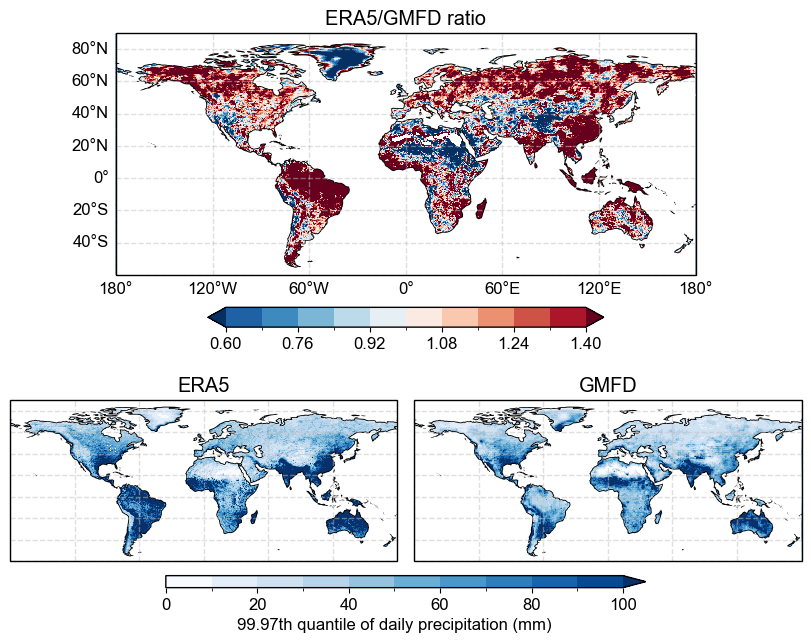

In [44]:
# 99.97th precip quantiles
fig = plt.figure(figsize=(8, 6), layout="constrained")

spec = fig.add_gridspec(2, 2, bottom=0.3, top=0.9, left=0.1, right=0.9, wspace=0.00, hspace=0.01)

# Ratio
ax0 = fig.add_subplot(spec[0, :], projection=ccrs.PlateCarree())
ratio = (era5_prcp.pr_rp10 / gmfd_prcp.pr_rp10).sel(lat=slice(-60, 90))
ratio.plot(
    ax=ax0,
    transform=ccrs.PlateCarree(),
    vmin=0.6,
    vmax=1.4,
    cmap="RdBu_r",
    levels=11,
    zorder=1,
    cbar_kwargs={
        "orientation": "horizontal",
        "label": None,
        "shrink": 0.5,
        "pad": 0.04,
    },
)
ax0.coastlines()
ax0.set_title("ERA5/GMFD ratio")

# ERA5
ax10 = fig.add_subplot(spec[1, 0], projection=ccrs.PlateCarree())
era5_prcp.pr_rp10.sel(lat=slice(-60, 90)).plot(
    ax=ax10,
    transform=ccrs.PlateCarree(),
    levels=11,
    zorder=1,
    add_colorbar=False,
    vmin=0,
    vmax=100,
    cmap="Blues",
)
ax10.set_title("ERA5")
ax10.coastlines()

# GMFD
ax11 = fig.add_subplot(spec[1, 1], projection=ccrs.PlateCarree())
p = gmfd_prcp.pr_rp10.sel(lat=slice(-60, 90)).plot(
    ax=ax11,
    transform=ccrs.PlateCarree(),
    levels=11,
    zorder=1,
    add_colorbar=False,
    vmin=0,
    vmax=100,
    cmap="Blues",
)

ax11.set_title("GMFD")
ax11.coastlines()

# Add colorbar
cbar_ax = fig.add_axes([0.2, 0.03, 0.6, 0.02])

cbar = fig.colorbar(
    p,
    cax=cbar_ax,
    orientation="horizontal",
    label="99.97th quantile of daily precipitation (mm)",
)

# Gridlines
for ax in [ax10, ax11]:
    ax.add_feature(cfeature.OCEAN, zorder=2, linewidth=0.001, color="white")
    ax.add_feature(cfeature.COASTLINE, linewidth=1.0)
    ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=False,
        linewidth=1,
        color="silver",
        alpha=0.5,
        linestyle="--",
    )


ax0.add_feature(cfeature.OCEAN, zorder=2, linewidth=0.001, color="white")
ax0.add_feature(cfeature.COASTLINE, linewidth=1.0)
ax0.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels={"bottom": "x", "left": "y"},
    linewidth=1,
    color="silver",
    alpha=0.5,
    linestyle="--",
)

plt.savefig("../figs/SI_map_obs_rp10_pr_comparison.png", dpi=600)

# Random example plots

In [2]:
###################
# Models
###################
from utils import cil_ssp_dict, deepsdbc_dict, gardsv_ssp_dict, gardsv_var_dict, isimip_ssp_dict, nex_ssp_dict

nex_models = list(nex_ssp_dict.keys())
cil_models = list(cil_ssp_dict.keys())
isi_models = list(isimip_ssp_dict.keys())
cbp_gard_models = list(gardsv_ssp_dict.keys())
cbp_gard_precip_models = [model for model in cbp_gard_models if "pr" in gardsv_var_dict[model]]
cbp_deep_models = list(deepsdbc_dict.keys())

In [32]:
###############################
# Set paths
# UPDATE THIS FOR REPRODUCTION
###############################
nex_in = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/nex-gddp/"
cil_in = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/cil-gdpcir/"
isi_in = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/isimip3b/regridded/conservative/"
cbp_in = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/carbonplan/"

out_path = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/results/"
poly_path = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/forced_response_polynomial/"

In [33]:
def read_and_process(ensemble, path_in, model, metric, submetric, submetric_var, lat, lon):
    # Read netcdf or zarr
    if ensemble in ["NEX", "ISIMIP", "GARD-SV"]:
        ds = xr.open_dataset(path_in + metric + "/" + model + ".nc")
    elif ensemble in ["CIL", "DeepSD-BC"]:
        ds = xr.open_dataset(path_in + metric + "/" + model, engine="zarr")

    # Select submetric if chosen
    if submetric:
        ds = ds[submetric]

    # Common preprocessing
    ds["time"] = ds.indexes["time"].year
    if ds.lon.max() > 180:
        ds["lon"] = np.where(ds["lon"] > 180, ds["lon"] - 360, ds["lon"])
        ds = ds.sortby("lon")

    # DeepSD-BC still has member_id
    if ensemble == "DeepSD-BC":
        ds = ds.isel(member_id=0)

    # Select lat, lon
    ds = ds.sel(lat=lat, lon=lon, method="nearest")

    # Construct dataframe
    df_tmp = ds.to_dataframe().drop(columns=["lat", "lon"]).reset_index()
    df_tmp["ensemble"] = ensemble
    df_tmp["model"] = model

    return df_tmp

In [34]:
def read_and_process_forced(ensemble, path_in, model, metric, submetric, submetric_var, lat, lon):
    poly_str = path_in + metric + "/"
    ds = xr.open_dataset(poly_str + ensemble + "_" + model + ".nc")
    ds["time"] = ds.indexes["time"].year

    # Select submetric if chosen
    if submetric:
        ds = ds[submetric]

    # DeepSD-BC still has member_id
    if ensemble == "DeepSD-BC":
        ds = ds.isel(member_id=0)

    # Select lat, lon
    ds = ds.sel(lat=lat, lon=lon, method="nearest")

    # Construct dataframe
    df_tmp = ds.to_dataframe().drop(columns=["lat", "lon"]).reset_index()
    df_tmp["ensemble"] = ensemble
    df_tmp["model"] = model

    return df_tmp

### Probability distributions

In [14]:
# Chicago, IL
lat, lon = 41.882, -87.628

# Common models
models = ["CanESM5", "EC-Earth3", "GFDL-ESM4", "MIROC6", "UKESM1-0-LL"]

var_id = "tasmax"

In [16]:
# Read all combinations
df = pd.DataFrame(columns=["time", "model", "ensemble", "ssp", var_id])

# NEX
for model in models:
    df_tmp = read_and_process("NEX", nex_in, model, "max", var_id, False, lat, lon)
    df = pd.concat([df, df_tmp])

# CIL
for model in models:
    df_tmp = read_and_process("CIL", cil_in, model, "max", var_id, False, lat, lon)
    df = pd.concat([df, df_tmp])

# ISIMIP
for model in models:
    df_tmp = read_and_process("ISIMIP", isi_in, model, "max", var_id, False, lat, lon)
    df = pd.concat([df, df_tmp])

# GARD-SV
for model in models:
    if model in cbp_gard_models:
        df_tmp = read_and_process(
            "GARD-SV",
            cbp_in + "/regridded/conservative/GARD-SV/",
            model,
            "max",
            var_id,
            False,
            lat,
            lon,
        )
        df = pd.concat([df, df_tmp])

# DeepSD-BC
for model in models:
    if model in cbp_deep_models:
        df_tmp = read_and_process(
            "DeepSD-BC",
            cbp_in + "native_grid/DeepSD-BC/",
            model,
            "max",
            var_id,
            False,
            lat,
            lon,
        )
        df = pd.concat([df, df_tmp])

In [17]:
# Select mid-century
df_mid = df.query("time >= 2045 and time <= 2055")

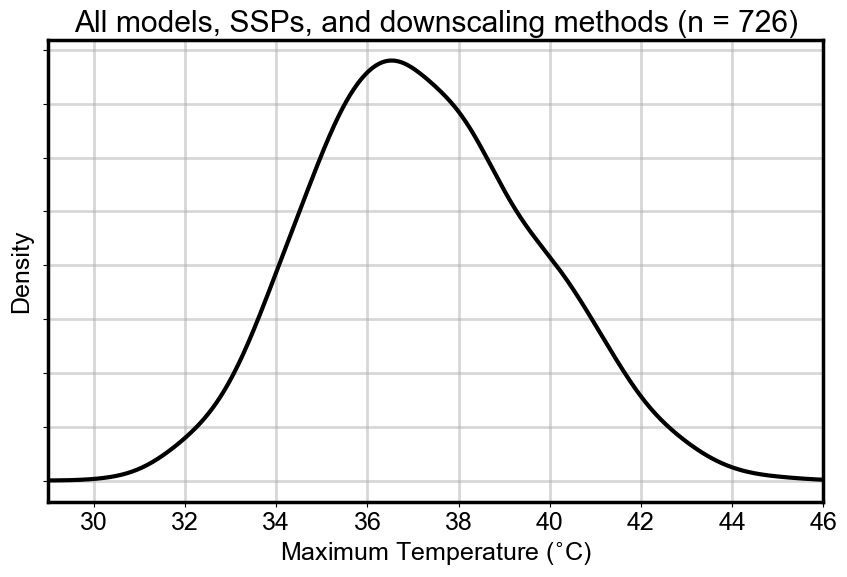

In [32]:
# Raw plot
fig, ax = plt.subplots(figsize=(10, 6))

df_mid[var_id].plot.kde(ax=ax, color="black", lw=3)

ax.set_title("All models, SSPs, and downscaling methods (n = " + str(len(df_mid)) + ")")
ax.set_xlabel("Maximum Temperature ($\!^\circ\!$C)")
ax.set_xlim([29, 46])
# ax.set_xlabel('Precipitation (mm)')
# ax.set_xlim([0,150])
ax.set_yticklabels([])
ax.grid(alpha=0.5, lw=2)
plt.savefig("../figs/supplementary/timeseries/Chicago_max_" + var_id + "_raw.png", dpi=600)

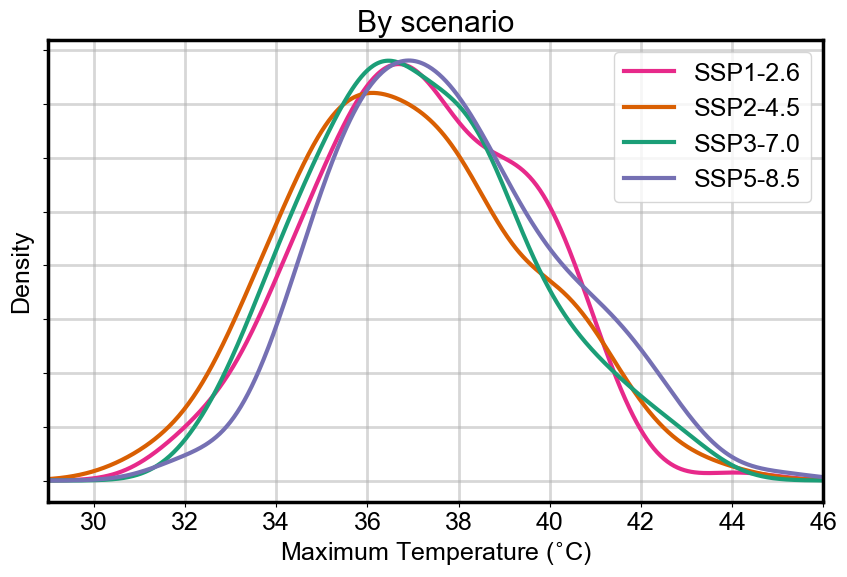

In [29]:
# SSP plot
ssp_color_dict = {
    "ssp126": "#e7298a",
    "ssp245": "#d95f02",
    "ssp370": "#1b9e77",
    "ssp585": "#7570b3",
}

fig, ax = plt.subplots(figsize=(10, 6))

df_mid.query('ssp == "ssp126"')[var_id].plot.kde(ax=ax, color=ssp_color_dict["ssp126"], label="SSP1-2.6", lw=3)
df_mid.query('ssp == "ssp245"')[var_id].plot.kde(ax=ax, color=ssp_color_dict["ssp245"], label="SSP2-4.5", lw=3)
df_mid.query('ssp == "ssp370"')[var_id].plot.kde(ax=ax, color=ssp_color_dict["ssp370"], label="SSP3-7.0", lw=3)
df_mid.query('ssp == "ssp585"')[var_id].plot.kde(ax=ax, color=ssp_color_dict["ssp585"], label="SSP5-8.5", lw=3)

ax.set_title("By scenario")
# ax.set_xlabel('Precipitation (mm)')
# ax.set_xlim([0,150])
ax.set_xlabel("Maximum Temperature ($\!^\circ\!$C)")
ax.set_xlim([29, 46])
ax.set_yticklabels([])
ax.grid(alpha=0.5, lw=2)
plt.legend()
plt.savefig("../figs/supplementary/timeseries/Chicago_max_" + var_id + "_ssp.png", dpi=600)

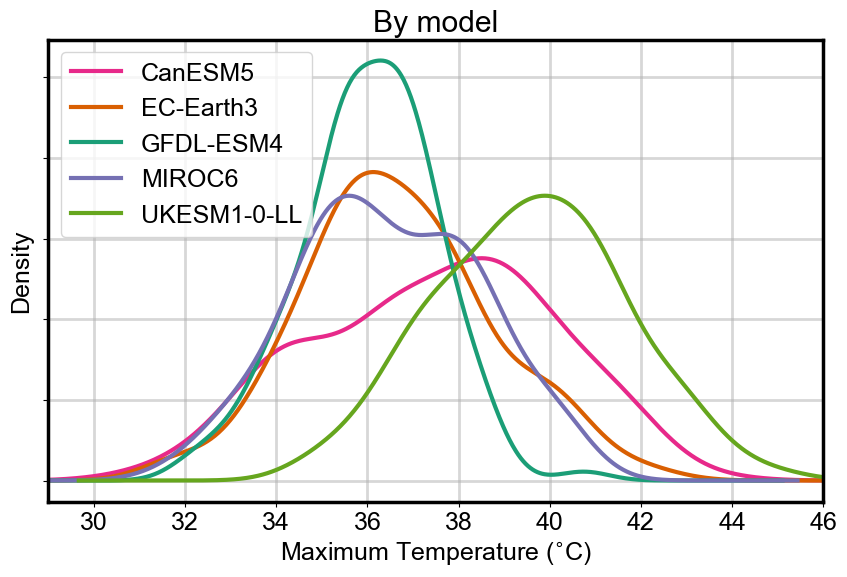

In [33]:
# Model plot
# models = reduce(lambda a, b: np.unique(np.append(a,b)), [nex_models, cil_models, isi_models])
model_color_dict = {
    models[0]: "#e7298a",
    models[1]: "#d95f02",
    models[2]: "#1b9e77",
    models[3]: "#7570b3",
    models[4]: "#66a61e",
}

fig, ax = plt.subplots(figsize=(10, 6))

for model in models:
    df_mid[df_mid.model == model][var_id].plot.kde(ax=ax, color=model_color_dict[model], lw=3, label=model)

ax.set_title("By model")
# ax.set_xlabel('Precipitation (mm)')
# ax.set_xlim([0,150])
ax.set_xlabel("Maximum Temperature ($\!^\circ\!$C)")
ax.set_xlim([29, 46])
ax.set_yticklabels([])
ax.grid(alpha=0.5, lw=2)
plt.legend()
plt.savefig("../figs/supplementary/timeseries/Chicago_max_" + var_id + "_models.png", dpi=600)

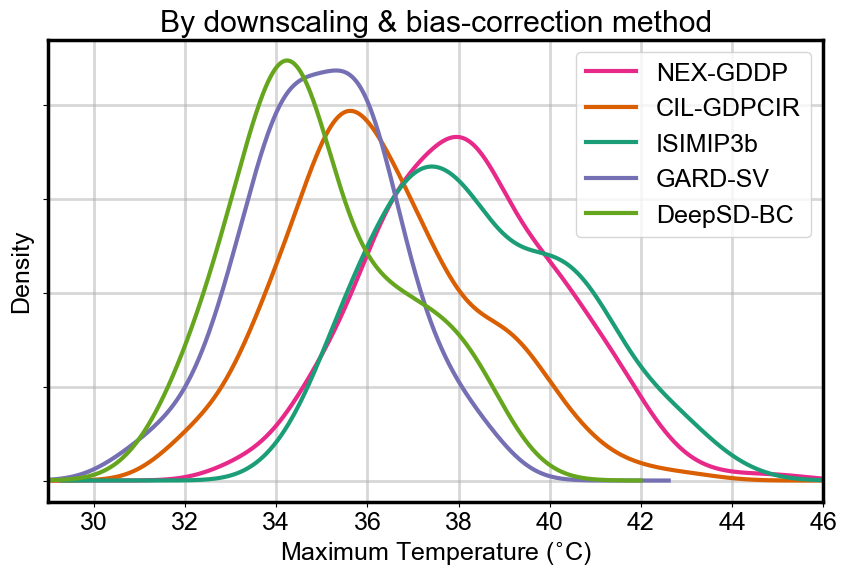

In [31]:
# Ensemble plot
ens_color_dict = {
    "NEX": "#e7298a",
    "CIL": "#d95f02",
    "ISIMIP": "#1b9e77",
    "GARD-SV": "#7570b3",
    "DeepSD-BC": "#66a61e",
}

fig, ax = plt.subplots(figsize=(10, 6))

df_mid.query('ensemble == "NEX"')[var_id].plot.kde(ax=ax, color=ens_color_dict["NEX"], label="NEX-GDDP", lw=3)
df_mid.query('ensemble == "CIL"')[var_id].plot.kde(ax=ax, color=ens_color_dict["CIL"], label="CIL-GDPCIR", lw=3)
df_mid.query('ensemble == "ISIMIP"')[var_id].plot.kde(ax=ax, color=ens_color_dict["ISIMIP"], label="ISIMIP3b", lw=3)
df_mid.query('ensemble == "GARD-SV"')[var_id].plot.kde(ax=ax, color=ens_color_dict["GARD-SV"], label="GARD-SV", lw=3)
df_mid.query('ensemble == "DeepSD-BC"')[var_id].plot.kde(
    ax=ax, color=ens_color_dict["DeepSD-BC"], label="DeepSD-BC", lw=3
)

ax.set_title("By downscaling & bias-correction method")
# ax.set_xlabel('Precipitation (mm)')
# ax.set_xlim([0,150])
ax.set_xlabel("Maximum Temperature ($\!^\circ\!$C)")
ax.set_xlim([29, 46])
ax.set_yticklabels([])
ax.grid(alpha=0.5, lw=2)
plt.legend()
plt.savefig("../figs/supplementary/timeseries/Chicago_max_" + var_id + "_ens.png", dpi=600)

### Timeseries

In [35]:
# Chicago, IL
lat, lon = 41.882, -87.628

# Metric
var_id = "tasmax"

In [ ]:
# Read all combinations
df = pd.DataFrame(columns=["time", "model", "ensemble", "ssp", var_id])

# NEX
for model in nex_models:
    df_tmp = read_and_process("NEX", nex_in, model, "max", var_id, False, lat, lon)
    df = pd.concat([df, df_tmp])

# CIL
for model in cil_models:
    df_tmp = read_and_process("CIL", cil_in, model, "max", var_id, False, lat, lon)
    df = pd.concat([df, df_tmp])

# ISIMIP
for model in isi_models:
    df_tmp = read_and_process("ISIMIP", isi_in, model, "max", var_id, False, lat, lon)
    df = pd.concat([df, df_tmp])

# GARD-SV
for model in cbp_gard_models:
    df_tmp = read_and_process(
        "GARD-SV",
        cbp_in + "/regridded/conservative/GARD-SV/",
        model,
        "max",
        var_id,
        False,
        lat,
        lon,
    )
    df = pd.concat([df, df_tmp])

# DeepSD-BC
for model in cbp_deep_models:
    df_tmp = read_and_process(
        "DeepSD-BC",
        cbp_in + "native_grid/DeepSD-BC/",
        model,
        "max",
        var_id,
        False,
        lat,
        lon,
    )
    df = pd.concat([df, df_tmp])

In [67]:
# Read all combinations
df_forced = pd.DataFrame(columns=["time", "model", "ensemble", "ssp", var_id])

# NEX
for model in nex_models:
    df_tmp = read_and_process_forced("NEX", poly_path, model, "max", var_id, False, lat, lon)
    df_forced = pd.concat([df_forced, df_tmp])

# CIL
for model in cil_models:
    df_tmp = read_and_process_forced("CIL", poly_path, model, "max", var_id, False, lat, lon)
    df_forced = pd.concat([df_forced, df_tmp])

# ISIMIP
for model in isi_models:
    df_tmp = read_and_process_forced("ISIMIP", poly_path, model, "max", var_id, False, lat, lon)
    df_forced = pd.concat([df_forced, df_tmp])

# GARD-SV
for model in cbp_gard_models:
    df_tmp = read_and_process_forced("GARD-SV", poly_path, model, "max", var_id, False, lat, lon)
    df_forced = pd.concat([df_forced, df_tmp])

# DeepSD-BC
for model in cbp_deep_models:
    df_tmp = read_and_process_forced("DeepSD-BC", poly_path, model, "max", var_id, False, lat, lon)
    df_forced = pd.concat([df_forced, df_tmp])

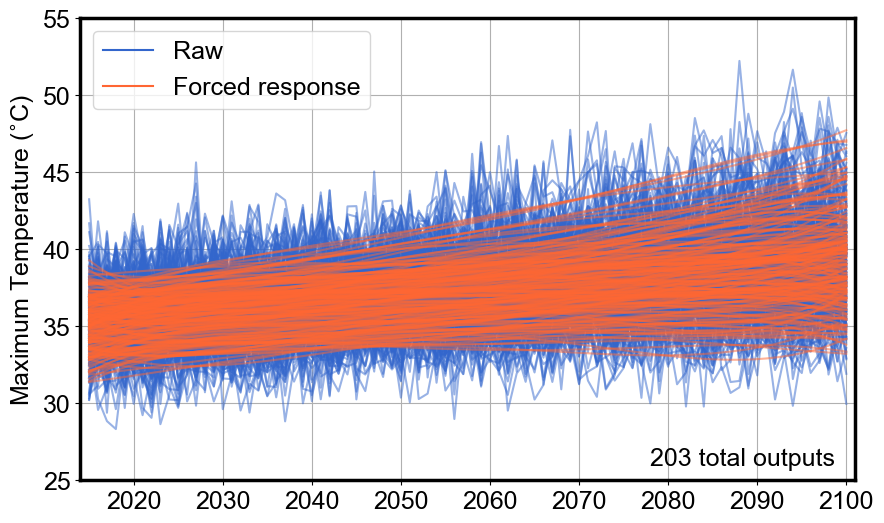

In [89]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot([1, 2], [3, 4], color="#3366CC", label="Raw")
ax.plot([1, 2], [3, 4], color="#FF6633", label="Forced response")
ax.legend()

df.groupby(["ensemble", "model", "ssp"]).plot(x="time", y=var_id, alpha=0.5, color="#3366CC", ax=ax, legend=None)
df_forced.groupby(["ensemble", "model", "ssp"]).plot(x="time", y=var_id, alpha=0.5, color="#FF6633", ax=ax, legend=None)

ax.set_ylabel("Maximum Temperature ($\!^\circ\!$C)")
ax.set_xlabel("")
ax.text(2078, 26, str(len(df[df.time == 2050])) + " total outputs")
ax.grid()
ax.set_xlim([2014, 2101])
ax.set_ylim([25, 55])
plt.savefig("../figs/supplementary/timeseries/Chicago_max_tasmax.png", dpi=800)

In [36]:
# Single example
df = pd.DataFrame(columns=["time", "model", "ensemble", "ssp", var_id])

# Raw
for model in nex_models[:1]:
    df_tmp = read_and_process("NEX", nex_in, model, "max", var_id, False, lat, lon)
    df = pd.concat([df, df_tmp])

# Forced
df_forced = pd.DataFrame(columns=["time", "model", "ensemble", "ssp", var_id])

for model in nex_models[:1]:
    df_tmp = read_and_process_forced("NEX", poly_path, model, "max", var_id, False, lat, lon)
    df_forced = pd.concat([df_forced, df_tmp])

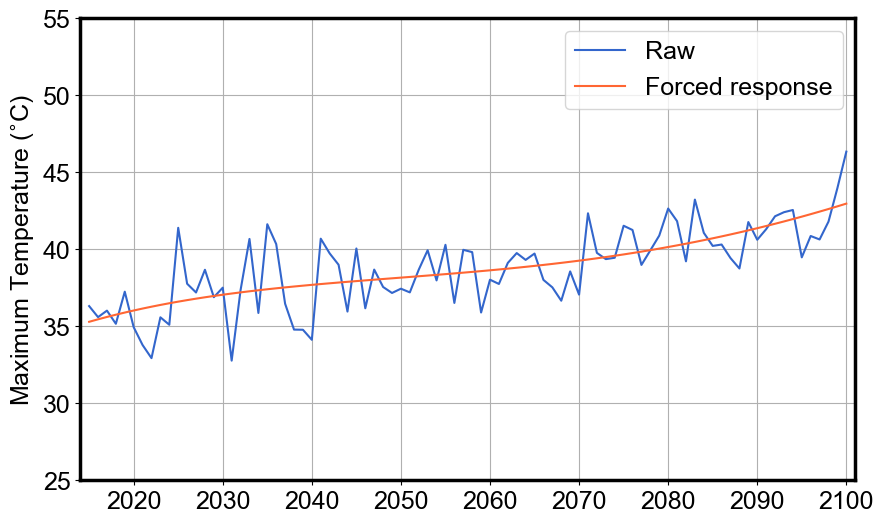

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot([1, 2], [3, 4], color="#3366CC", label="Raw")
ax.plot([1, 2], [3, 4], color="#FF6633", label="Forced response")
ax.legend()

ssp = "ssp585"
df[df.ssp == ssp].plot(x="time", y=var_id, alpha=1, color="#3366CC", ax=ax, legend=None)
df_forced[df_forced.ssp == ssp].plot(x="time", y=var_id, alpha=1, color="#FF6633", ax=ax, legend=None)

ax.set_ylabel("Maximum Temperature ($\!^\circ\!$C)")
ax.set_xlabel("")
ax.grid()
ax.set_xlim([2014, 2101])
ax.set_ylim([25, 55])
plt.savefig("../figs/supplementary/timeseries/Chicago_max_tasmax_single.png", dpi=800)
# plt.show()

# Checking the metrics

### Preliminaries

In [2]:
###################
# Models
###################
from utils import cil_ssp_dict, deepsdbc_dict, gardsv_ssp_dict, gardsv_var_dict, isimip_ssp_dict, nex_ssp_dict

nex_models = list(nex_ssp_dict.keys())
cil_models = list(cil_ssp_dict.keys())
isi_models = list(isimip_ssp_dict.keys())
cbp_gard_models = list(gardsv_ssp_dict.keys())
cbp_gard_precip_models = [model for model in cbp_gard_models if "pr" in gardsv_var_dict[model]]
cbp_deep_models = list(deepsdbc_dict.keys())

In [ ]:
############
# Dask
############
from dask_jobqueue import PBSCluster

cluster = PBSCluster(
    cores=1,
    memory="15GB",
    resource_spec="pmem=15GB",
    worker_extra_args=["#PBS -l feature=rhel7"],
    walltime="00:10:00",
)

cluster.scale(jobs=5)  # ask for jobs

from dask.distributed import Client

client = Client(cluster)

client

### Plots

In [3]:
###############################
# Set paths
# UPDATE THIS FOR REPRODUCTION
###############################
path_in = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/"
path_out = "/storage/home/dcl5300/work/lafferty-sriver_inprep_tbd/figs/supplementary/"

In [12]:
def make_metric_plot(ensemble, model, ssps, path_in, metric, var_id, path_out):
    out_str = path_out + metric + "/" + var_id + "/" + ensemble + "_" + model + "_" + metric + "_" + var_id + ".png"
    if os.path.isfile(out_str):
        return "Already done"
    else:
        # Figure details
        fig, axs = plt.subplots(
            nrows=2,
            ncols=2,
            figsize=(10, 6),
            subplot_kw=dict(projection=ccrs.PlateCarree()),
        )
        axs = axs.flatten()

        fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9, wspace=0.02, hspace=0.01)

        fig.suptitle(
            ensemble + "_" + model + "_" + metric + "_" + var_id,
            fontsize=12,
            fontweight="bold",
            y=0.95,
        )

        # Read netcdf or zarr
        if ensemble in ["cil-gdpcir", "DeepSD-BC"]:
            ds = xr.open_dataset(path_in + ensemble + "/" + metric + "/" + model, engine="zarr")
        elif ensemble == "isimip3b":
            ds = xr.open_dataset(path_in + metric + "/" + model + ".nc")
        else:
            ds = xr.open_dataset(path_in + ensemble + "/" + metric + "/" + model + ".nc")

        # Slice
        ds = ds.sel(lat=slice(-60, 90))

        # Select variable
        if var_id in list(ds.data_vars):
            ds = ds[var_id]

        # Plot by ssp
        for idx, ssp in enumerate(ssps):
            # hard-code the one exception
            if (ensemble == "DeepSD-BC") and (ssp == "ssp585") and (var_id == "pr") and (model == "MRI-ESM2-0"):
                continue
            else:
                try:
                    p = (
                        ds.sel(ssp=ssp)
                        .isel(time=80)
                        .plot(
                            transform=ccrs.PlateCarree(),
                            add_colorbar=False,
                            ax=axs[idx],
                            levels=11,
                        )
                    )
                    axs[idx].set_title(ssp)
                    map_exists = True
                except:
                    axs[idx].set_title(ssp + " ERROR")
                    map_exists = False

        # Single colorbar
        if map_exists:
            cbar_ax = fig.add_axes([0.2, 0.16, 0.6, 0.02])

            cbar = fig.colorbar(p, cax=cbar_ax, orientation="horizontal", label=metric + " " + var_id)

        plt.savefig(out_str, dpi=300)
        # plt.show()

In [9]:
%%time
################
# avg, max
###############
delayed_res = []
for metric in ["avg", "max"]:
    for var_id in ["tas", "tasmin", "tasmax", "pr"]:
        # NEX
        for model in nex_models:
            delayed_res.append(
                dask.delayed(make_metric_plot)(
                    "nex-gddp",
                    model,
                    nex_ssp_dict[model],
                    path_in,
                    metric,
                    var_id,
                    path_out,
                )
            )

        # CIL
        for model in cil_models:
            delayed_res.append(
                dask.delayed(make_metric_plot)(
                    "cil-gdpcir",
                    model,
                    cil_ssp_dict[model],
                    path_in,
                    metric,
                    var_id,
                    path_out,
                )
            )

        # ISIMIP
        for model in isi_models:
            delayed_res.append(
                dask.delayed(make_metric_plot)(
                    "isimip3b",
                    model,
                    isimip_ssp_dict[model],
                    path_in + "isimip3b/regridded/conservative/",
                    metric,
                    var_id,
                    path_out,
                )
            )

        # GARD-SV
        if var_id == "pr":
            model_list = cbp_gard_precip_models
        else:
            model_list = cbp_gard_models
        for model in model_list:
            delayed_res.append(
                dask.delayed(make_metric_plot)(
                    "GARD-SV",
                    model,
                    gardsv_ssp_dict[model],
                    path_in + "carbonplan/regridded/conservative/",
                    metric,
                    var_id,
                    path_out,
                )
            )

        # DeepSD-BC
        for model in cbp_deep_models:
            delayed_res.append(
                dask.delayed(make_metric_plot)(
                    "DeepSD-BC",
                    model,
                    deepsdbc_dict[model].keys(),
                    path_in + "carbonplan/native_grid/",
                    metric,
                    var_id,
                    path_out,
                )
            )

################
# max5d
#################
metric = "max5d"
var_id = "RX5day"

# NEX
for model in nex_models:
    delayed_res.append(
        dask.delayed(make_metric_plot)("nex-gddp", model, nex_ssp_dict[model], path_in, metric, var_id, path_out)
    )

# CIL
for model in cil_models:
    delayed_res.append(
        dask.delayed(make_metric_plot)("cil-gdpcir", model, cil_ssp_dict[model], path_in, metric, var_id, path_out)
    )

# ISIMIP
for model in isi_models:
    delayed_res.append(
        dask.delayed(make_metric_plot)(
            "isimip3b",
            model,
            isimip_ssp_dict[model],
            path_in + "isimip3b/regridded/conservative/",
            metric,
            var_id,
            path_out,
        )
    )

# GARD-SV
for model in cbp_gard_precip_models:
    delayed_res.append(
        dask.delayed(make_metric_plot)(
            "GARD-SV",
            model,
            gardsv_ssp_dict[model],
            path_in + "carbonplan/regridded/conservative/",
            metric,
            var_id,
            path_out,
        )
    )

# DeepSD-BC
for model in cbp_deep_models:
    delayed_res.append(
        dask.delayed(make_metric_plot)(
            "DeepSD-BC",
            model,
            deepsdbc_dict[model].keys(),
            path_in + "carbonplan/native_grid/",
            metric,
            var_id,
            path_out,
        )
    )

#############
# dry
#############
metric = "dry"

for var_id in ["count_eq_0", "count_lt_1", "streak_eq_0", "streak_lt_1"]:
    # NEX
    for model in nex_models:
        delayed_res.append(
            dask.delayed(make_metric_plot)(
                "nex-gddp",
                model,
                nex_ssp_dict[model],
                path_in,
                metric,
                var_id,
                path_out,
            )
        )

    # CIL
    for model in cil_models:
        delayed_res.append(
            dask.delayed(make_metric_plot)(
                "cil-gdpcir",
                model,
                cil_ssp_dict[model],
                path_in,
                metric,
                var_id,
                path_out,
            )
        )

    # ISIMIP
    for model in isi_models:
        delayed_res.append(
            dask.delayed(make_metric_plot)(
                "isimip3b",
                model,
                isimip_ssp_dict[model],
                path_in + "isimip3b/regridded/conservative/",
                metric,
                var_id,
                path_out,
            )
        )

    # GARD-SV
    for model in cbp_gard_precip_models:
        delayed_res.append(
            dask.delayed(make_metric_plot)(
                "GARD-SV",
                model,
                gardsv_ssp_dict[model],
                path_in + "carbonplan/regridded/conservative/",
                metric,
                var_id,
                path_out,
            )
        )

    # DeepSD-BC
    for model in cbp_deep_models:
        delayed_res.append(
            dask.delayed(make_metric_plot)(
                "DeepSD-BC",
                model,
                deepsdbc_dict[model].keys(),
                path_in + "carbonplan/native_grid/",
                metric,
                var_id,
                path_out,
            )
        )


# Compute
print(len(delayed_res))
res = dask.compute(*delayed_res)

701
CPU times: user 1.73 s, sys: 123 ms, total: 1.85 s
Wall time: 8.49 s
